In [2]:
import os
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from pathlib import Path
import matplotlib.pyplot as plt
import datetime
from scipy import stats

In [3]:
# need to install statsmodels
#!pip3 install statsmodels
!pip3 install pmdarima

You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
DSDATA = Path(os.getenv('DSDATA'))
print(DSDATA)

/Users/macbookpro/Desktop/DLSU/9th_Term/DATASCI/DSDATA


In [5]:
folder = DSDATA / 'RETAIL_PRICES' #for crops
mfolder = DSDATA / 'MEATS' #for MEAT
afolder = DSDATA / 'ALL_CROPS' 
amfolder = DSDATA / 'ALL_MEATS'
geofolder = DSDATA / 'FOOD_BY_GEO'
cpifolder = DSDATA / 'CPI'

In [6]:
#make folder if none was created
def makefolder(path):
    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
    else:
        print ("Successfully created the directory %s " % path)

## Since openstat can only allow 100,000 rows per download, we need to combine all the data with the same name.
for example : 
 1. merge `BEANS_1`, `BEANS_2` to become ALL_BEANS 
     1. get the index at which the filename changes (example from BEANS_1. to CEREAL_1, the index of that the file name changed is 1)
     2. check if the geolocation and comodotity group is the same per row after combininng 
     3. combine all the same crop category using it's index
 2. When all of the files have been merge to it's corresponding files, we aggragate it to one dataframe 
 3. the whole dataframe can be seperated by provincial,regional and national 

In [7]:
#remove DSstore
def remove_DS_STORE(filenamess):
    try:
        filenamess.remove('.DS_Store')
    except ValueError: 
        print("No .DS_Store")
    return filenamess
#1.A
 # crop category for naming the files
def get_file_names(tempfile):
    counter =0
    current = '' 
    index_changed = []
    crop_cat = []
    for x in range(len(tempfile)):
        if(tempfile[x].split("_")[0] != current):
            current = tempfile[x].split("_")[0]
            index_changed.append(x)
            crop_cat.append(tempfile[x].split("_")[0])
        counter += 1

    index_changed.append(len(tempfile))
    print(index_changed)
    print(crop_cat)
    return index_changed,crop_cat

onlyfiles = [f for f in listdir(folder) if isfile(join(folder, f))]
meatfiles = [f for f in listdir(mfolder) if isfile(join(mfolder, f))]

onlyfiles = list(np.sort(onlyfiles))
meatfiles = list(np.sort(meatfiles))



onlyfiles = remove_DS_STORE(onlyfiles)
meatfiles=remove_DS_STORE(meatfiles)

vindex,vfiles = get_file_names(onlyfiles)
mindex,mfiles = get_file_names(meatfiles)

No .DS_Store
[0, 2, 6, 8, 11, 13, 15, 19]
['BEANS', 'CEREAL', 'CONDIMENTS', 'FRUIT', 'LVEG', 'RCROPS', 'TFRUIT']
[0, 2, 4, 9]
['Beef', 'POULTRY', 'SEAFOOD']


## Used a nested loop to concatinate the same crop category.
merging on `Geolocation` and `Commodity` makes sure that each row had the same `Geolocation` and `Commodity` hence concating columns which have the same `Geolocation` and `Commodity`


In [8]:
#1.B

def merge_all_years(file_index_counter,filenamess,file_location,crop_cat,save_to):
    makefolder(save_to)
    crop_index = 0 
    current = pd.DataFrame()
    for i in range(1,len(file_index_counter)):
        for merger in range(file_index_counter[i-1],file_index_counter[i]):
            df2 = pd.read_csv(DSDATA / file_location / str(filenamess[merger]), skiprows=1, encoding = "ISO-8859-1")
            print(merger)
            if current.empty==False:
                print(filenamess[merger])
                print("geolocation")
                print(current['Geolocation'].equals(df2['Geolocation']))
                print("commodity")
                print(current['Commodity'].equals(df2['Commodity']))
                current = pd.merge(current,df2,on = ["Geolocation","Commodity"],how="left")
                
            else:
                current = df2
        filename='ALL_'+ crop_cat[crop_index] +'.csv'
        current.to_csv(save_to / filename , index=False)# saved to a specified file
        crop_index += 1
        new_df= pd.DataFrame()
        current= new_df


merge_all_years(vindex,onlyfiles,'RETAIL_PRICES',vfiles, afolder)
merge_all_years(mindex,meatfiles,'MEATS',mfiles, amfolder)

Creation of the directory /Users/macbookpro/Desktop/DLSU/9th_Term/DATASCI/DSDATA/ALL_CROPS failed
0
1
BEANS_2.csv
geolocation
True
commodity
True
2
3
CEREAL_2.csv
geolocation
True
commodity
True
4
CEREAL_3.csv
geolocation
True
commodity
True
5
CEREAL_4.csv
geolocation
True
commodity
True
6
7
CONDIMENTS_2.csv
geolocation
True
commodity
True
8
9
FRUIT_2.csv
geolocation
True
commodity
True
10
FRUIT_3.csv
geolocation
True
commodity
True
11
12
LVEG_2.csv
geolocation
True
commodity
True
13
14
RCROPS_2.csv
geolocation
True
commodity
True
15
16
TFRUIT_2.csv
geolocation
True
commodity
True
17
TFRUIT_3.csv
geolocation
True
commodity
True
18
TFRUIT_4.csv
geolocation
True
commodity
True
Creation of the directory /Users/macbookpro/Desktop/DLSU/9th_Term/DATASCI/DSDATA/ALL_MEATS failed
0
1
Beef_Pork_2.csv
geolocation
True
commodity
True
2
3
POULTRY_2.csv
geolocation
True
commodity
True
4
5
SEAFOOD_2.csv
geolocation
True
commodity
True
6
SEAFOOD_3.csv
geolocation
True
commodity
True
7
SEAFOOD_4.csv
ge

In [9]:
all_files = [f for f in listdir(afolder) if isfile(join(afolder, f))]
ameat_files = [f for f in listdir(amfolder) if isfile(join(amfolder, f))]
all_files
print(all_files[0])

ALL_RCROPS.csv


# 1.3 To extract using geo_level from all the excel files
1. Created a dcitionary that contains all of the region named `dict_geo`
2. Made a new categorical column named `geo_level`(0-provincial 1-regoinal 2-national) by using `dict_geo` 
3. Extract by `geo_level` and make a new dataframe per geolocation level (0-provincial 1-regoinal 2-national)  

In [10]:
#encoding = "ISO-8859-1" because there is an error for utf-8

data = pd.read_csv(DSDATA / 'ALL_CROPS'/ all_files[0], encoding = "ISO-8859-1")
def get_regions(locations):
    region = []
    for location in locations:
        if location !="PHILIPPINES" and location == location.upper():
            region.append(location)
    return np.unique(region)

regions = get_regions(data['Geolocation'])


# regoin turn into a dictionary
dict_geo = { i: 1 for i in regions}
dict_geo.update( {'PHILIPPINES' : 2} )

In [11]:
##if applicaple
#all_files.remove('.DS_Store')


# Function Desc_analysis
- Prints the following:
    - null values
    - number of rows
    - number of columns
    - percentage of missing values

In [12]:
def desc_analysis(df):
    df.head()
    print("number of null values is {} ".format(df.isnull().sum().sum()))
    print("number of rows {} ".format(df.shape[0]))
    print("number of columns {} ".format(df.shape[1]))
    missing_p =((df.isnull().sum().sum())/(df.shape[0]*df.shape[1])) *100
    print("missing values in percentage {:.2f} ".format(missing_p))
          

# Descriptive analysis for food comodities (National level)

## Pre-processed
- Created `desc_analysis function` print the following:
    - size of rows:
    - size of columns:
    - names of the columns:
    - null values:
    - percentage of missing values:
    - Data dictionary
        - Geolevel
            - **P**: province
            - **R**: regional
            - **N**: national
            - **all**: every regional level combined
         
    
| Food_comodity    | Geo_level | # of rows | # of columns | # of missing | % of missing |
|------------------|-----------|-----------|--------------|--------------|--------------|
| Crops            | P         | 3,280     | 393          | 383,940      | 29.78%       |
| Crops            | R         | 680       | 393          | 28,509       | 10.67%       |
| Crops            | N         | 40        | 393          | 518          | 3.30%        |
| Crops(total)     | all       | 4,000     | 393          | 412,967      | 26.27%       |
| Seafood          | P         | 984       | 393          | 121,466      | 31.40%       |
| Seafood          | R         | 204       | 393          | 3,349        | 4.18%        |
| Seafood          | N         | 12        | 393          | 97           | 2.06%        |
| Seafood(total)   | all       | 1,200     | 393          | 124,912      | 26.48%       |
| Beef_Pork        | P         | 410       | 393          | 29,260       | 18.16%       |
| Beef_Pork        | R         | 85        | 393          | 943          | 2.82%        |
| Beef_Pork        | N         | 5         | 393          | 53           | 2.70%        |
| Beef_Pork(total) | all       | 500       | 393          | 30,256       | 15.39%       |
| Poultry          | P         | 328       | 393          | 63,577       | 49.32%       |
| Poultry          | R         | 68        | 393          | 8,102        | 30.32%       |
| Poultry          | N         | 4         | 393          | 58           | 3.69%        |
| Poultry(total)   | all       | 400       | 393          | 71,731       | 45.68%       |

## Processing
![alt text](https://miro.medium.com/max/1400/1*_RA3mCS30Pr0vUxbp25Yxw.png) 
- source: https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4
- given tha chart, we will replace the null values by the mean(per row) since the dataset is a timeseries data using  a fuction named `processor`
- however we delete data starting from june2019 because the last update was until may 2019
- `loop_processor` is a function that loops through all the dataset present in the folder `FOOD_BY_GEO` and call `processor` every time a new file is read.

DataCleaning
- check which years to would have less NaN values 
- make a treshold if you are going keep the row or not (51%)
- remove the rows with 0 mean (if exists)


## Post-processed
- created a function 
- size of rows:
- size of columns:
- column names:
- null values:

### Data Cleaning:
- initially the regions have a .. before the text, for example a value for a geolocation was`..NATIONAL CAPITAL REGION (NCR)` now we turn it into `NATIONAL CAPITAL REGION (NCR)`
    - provincial: `....Abra` to `Abra`
    - regoinal: `..NATIONAL CAPITAL REGION (NCR)` to `NATIONAL CAPITAL REGION (NCR)`
- blank values are shown as `..` thus 
    - changing `..` to `np.NaN`


In [13]:
def remove_extra_dots(df,geo): #geo=1 province, 2 region
    if(geo==1):
        print("province")
        df["Geolocation"] = df["Geolocation"].str[4:]
    elif(geo==2):
        print("regoinal")
        df["Geolocation"] = df["Geolocation"].str[2:]
    else:
        print("national")
    df = df.replace('..',np.nan)
    desc_analysis(df)
    return df


try:
    all_files.remove('.DS_Store')
except ValueError: 
     print("No .DS_Store")
        
def geo_seperator(all_files,file_location,save_to):
    makefolder(save_to)
    all_provc = pd.DataFrame()
    all_regc = pd.DataFrame()
    all_phc = pd.DataFrame()
    for x in all_files:
        glevel=[]
        data = pd.read_csv(DSDATA / file_location / x , encoding = "ISO-8859-1")
        for location in data['Geolocation']: 
            try:
                glevel.append(dict_geo[location])
            except KeyError:
                glevel.append(0)
        data["geo_level"] = glevel
        

        #extracting geo level per file
    
        to_prov_file = data[data['geo_level']==0].reset_index(drop=True)
        to_reg_file = data[data['geo_level']==1].reset_index(drop=True)
        to_ph_file = data[data['geo_level']==2].reset_index(drop=True)
        #appending the extracted file to one file 
        #output: all_provc : provinces geo level of crops
        #output: all_regc : regional geo level of crops
        #output: all_phc : national geo level of crops
        #remove .. before the name of the region
        all_provc = all_provc.append(to_prov_file,ignore_index = True)
        all_regc = all_regc.append(to_reg_file)
        all_phc = all_phc.append(to_ph_file)
        if(file_location=="ALL_MEATS"): #IF MEATS FILE CREATE EVERY 
            filename = x.split("_")[1]
            p = 'provincial_'+ filename  
            r = 'regoinal_'+ filename 
            n = 'national_'+ filename 
            
            print(x)
            all_provc = remove_extra_dots(all_provc,1)
            all_provc.to_csv(geofolder/p, index=False)
            
            all_regc = remove_extra_dots(all_regc,2)
            all_regc.to_csv(geofolder/r, index=False)
            
            all_phc = remove_extra_dots(all_phc,3)
            all_phc.to_csv(geofolder/n, index=False)
            
            all_provc = pd.DataFrame()
            all_regc = pd.DataFrame()
            all_phc = pd.DataFrame()
            
    if(file_location!="ALL_MEATS"): # if CROPS FILE APPEND EVERYTHING TO ONE FILE
        print(x)
        
        all_provc = remove_extra_dots(all_provc,1)
        all_provc.to_csv(geofolder/'provincial_CROPS.csv', index=False)
        
        all_regc = remove_extra_dots(all_regc,2)
        all_regc.to_csv(geofolder/'regoinal_CROPS.csv', index=False)
        
        all_phc = remove_extra_dots(all_phc,3)
        all_phc.to_csv(geofolder/'national_CROPS.csv', index=False)


geo_seperator(all_files,'ALL_CROPS', geofolder)
geo_seperator(ameat_files,'ALL_MEATS', geofolder)
#initializaing geofiles
geofiles = [f for f in listdir(geofolder) if isfile(join(geofolder, f))]
try:
    geofiles.remove('.DS_Store')
except ValueError: 
     print("No .DS_Store")
#geo_seperator(_files,'ALL_CROPS')
#afolder = DSDATA / 'ALL_RETAIL' 
#all_files = [f for f in listdir(afolder) if isfile(join(afolder, f))]

No .DS_Store
Creation of the directory /Users/macbookpro/Desktop/DLSU/9th_Term/DATASCI/DSDATA/FOOD_BY_GEO failed
ALL_TFRUIT.csv
province
number of null values is 383940 
number of rows 3280 
number of columns 393 
missing values in percentage 29.78 
regoinal
number of null values is 28509 
number of rows 680 
number of columns 393 
missing values in percentage 10.67 
national
number of null values is 518 
number of rows 40 
number of columns 393 
missing values in percentage 3.30 
Creation of the directory /Users/macbookpro/Desktop/DLSU/9th_Term/DATASCI/DSDATA/FOOD_BY_GEO failed
ALL_SEAFOOD.csv
province
number of null values is 121446 
number of rows 984 
number of columns 393 
missing values in percentage 31.40 
regoinal
number of null values is 3349 
number of rows 204 
number of columns 393 
missing values in percentage 4.18 
national
number of null values is 97 
number of rows 12 
number of columns 393 
missing values in percentage 2.06 
ALL_POULTRY.csv
province
number of null valu

# Function Processor
- to replace nan values to the mean (average price of the food commofity) of the row 
- input: dataframe
- output: processed dataframe


# Loop_processor
- loops through the national geolevel files apply the processor function 
- input: file location (where to save the processed csv), file_names (file names apply the function)
- output: csv_processed

In [14]:
# filling the values with the mean
def processor(df):
    #makes the last column may 2019
    df = df.iloc[:,:-9]
    df['avg'] = df.mean(axis=1)
    #display(df)
    #Row-by-row fillna with respect to a specific column
    df = df.apply(lambda x: x.fillna(value=df['avg']))
    df = df.iloc[:,:-1]
    return df
    #return df

In [15]:
def loop_processor(file_location,file_names):
    for file_name in file_names:
        added="national" in file_name 
        if(file_name !='DS_Store' and added):
            data = pd.read_csv(DSDATA/file_location/file_name)
            data = processor(data)
            #display(data)
            print(file_name)
            if(len(file_name.split("_"))==2):
                file_name = file_name.split('.')[0]+"_Processed.csv"
                print(file_name)
            data.to_csv(geofolder/file_name,index=False)


In [16]:
national_f = []
geofolder = DSDATA / 'FOOD_BY_GEO'
geofiles = [f for f in listdir(geofolder) if isfile(join(geofolder, f))]
geofiles = remove_DS_STORE(geofiles)


No .DS_Store


In [17]:

#geofiles=geofiles.remove('.DS_Store')

loop_processor('FOOD_BY_GEO',geofiles)

geofiles = [f for f in listdir(geofolder) if isfile(join(geofolder, f))]
geofiles = remove_DS_STORE(geofiles)
geofiles

for x in geofiles:
    if '_Processed' in x and x != '.DS_Store':
        national_f.append(x)

for file_name in national_f:
        data = pd.read_csv(DSDATA/'FOOD_BY_GEO'/file_name)
        print(file_name)
        desc_analysis(data)
        


national_SEAFOOD_Processed.csv
national_Beef.csv
national_Beef_Processed.csv
national_CROPS.csv
national_CROPS_Processed.csv
national_Beef_Processed_CPI.csv
national_SEAFOOD.csv
national_SEAFOOD_Processed.csv
national_POULTRY_Processed.csv
national_Beef_Processed.csv
national_CROPS_Processed.csv
national_POULTRY.csv
national_POULTRY_Processed.csv
national_SEAFOOD_Processed_CPI.csv
national_POULTRY_Processed_CPI.csv
national_CROPS_Processed_CPI.csv
No .DS_Store
national_SEAFOOD_Processed.csv
number of null values is 0 
number of rows 12 
number of columns 384 
missing values in percentage 0.00 
national_Beef_Processed_CPI.csv
number of null values is 0 
number of rows 5 
number of columns 346 
missing values in percentage 0.00 
national_POULTRY_Processed.csv
number of null values is 0 
number of rows 4 
number of columns 384 
missing values in percentage 0.00 
national_Beef_Processed.csv
number of null values is 0 
number of rows 5 
number of columns 375 
missing values in percentage 0.

# FOR GEOSPATIAL GRAPHS


#### Creating an array have a boolean for which row is a region 
1 = true  
0 = false

In [18]:
national_f

['national_SEAFOOD_Processed.csv',
 'national_Beef_Processed_CPI.csv',
 'national_POULTRY_Processed.csv',
 'national_Beef_Processed.csv',
 'national_CROPS_Processed.csv',
 'national_SEAFOOD_Processed_CPI.csv',
 'national_POULTRY_Processed_CPI.csv',
 'national_CROPS_Processed_CPI.csv']

# Descriptive analysis National Geo level 
## Post processed

| Food_comodity | # of rows | # of columns | # of missing | % of missing |
|---------------|-----------|--------------|--------------|--------------|
| Crops         | 40        | 385          | 0            | 0            |
| Seafood       | 12        | 385          | 0            | 0            |
| Beef_Pork     | 5         | 385          | 0            | 0            |
| Poultry       | 4         | 385          | 0            | 0            |

# Reading the Consumer Price Index(CPI)

In [19]:
df = pd.read_excel(open(cpifolder/"prices2012.xls","rb"), sheet_name='PH',skiprows =2)

# CPI
In an article published by the State of California, historical prices were converted to their current price using CPI of the corresponding years.  
Example: Converting 1950’s 0.25 cents to prices from 1998
- The CPI for 1950 = 24.1
- The CPI for 1998 = 163.0
- 1998 price = 1950 price x (1998 CPI/1995 CPI)
- 1998 price =  0.25  x ( 163 / 24.1)
- 1998 price = 1.69

we create a `multiplier` column by (may 2019 cpi/ current row cpi) to be able multiply the row with the corresponding  the food price that has the same year.

lastly we save the multiplier column to `M_CPI.csv`


In [47]:
#get data from 1990 till 2019
#df[df['Year']==1990] index=384
cpi_90_19 = df.iloc[384:,0:3].reset_index(drop=True)
last_cpi = cpi_90_19.iloc[-1,2]
multiplier = []

print(last_cpi)
for x in cpi_90_19['All Items']:
    multiplier.append(float(last_cpi/x))
    
cpi_90_19['multiplier'] = multiplier
p="M_CPI.csv"
cpi_90_19.to_csv(cpifolder/p, index=False)

119.8


## Making a new table for conversion of the historical prices to the current prices
- `national_f` is a list that contains all the prices from crops,beef and pork, poultry, and seafood.
- we multiply the prices per year using the `mulutplier` column in `cpi_90_19` using a function named `normaliser`
    - the `normaliser` transposed cpi_90_19 ( `t_cpi`) , so the order would be the same with the food commodities dataframe (order is monthly startnig from January 1990)
    - However there is a mismatch among sizes of cpi_90_19 and food comodities columns since
        - **reason** : food comodities columns contains annual prices after each years december entry
        - **solution** : remove the anual data using `annual_separator` and store anual data 

In [41]:
def normaliser(df):
    ctr=0
    temp = list(cpi_90_19['multiplier'])
    ## adds 2 values since there is 
    rows = df.shape[0]
    ## remove annual columns
    df = df[df.columns.drop(list(df.filter(regex='Annual')))]
    #df.iloc[rows-1] = temp
    prices = pd.DataFrame()
    #multiplying by the multiplier
    print(df.shape)
    print(len(temp))
    for x in df.columns:
        if(x!= 'Geolocation' and x != 'Commodity'):
            prices[x] = df.loc[:,x].astype(int)*  temp[ctr] 
            ctr= ctr+1
    #replaced all the columns to the normalised version (multiplied by the multiplier)
    # starts at column2 since we there is geolocation column and commodity
    df.iloc[:,2:] = prices
    return df



# Null Hypothesis


• The two-tailed alternative hypothesis (H1) assumes that the difference between the true mean (μ) and the comparison value (m0) is not equal to zero.

In [43]:
def one_sample(data, year):
    reject_th0 = []
    accept_th0 = []
    # go through all the rows
    years = year * -1
    data_filtered = data.filter(regex='Annual')
    for x in range(data.shape[0]):
        #average of the current year
        known_mean = data.iloc[x,-5:].mean()
        #dataframe that has the anual table
        sample = data_filtered.iloc[x,years:]
        one_sample = stats.ttest_1samp(sample, known_mean)
        if one_sample.pvalue >0.05 :
            accept_th0.append(data.loc[x,'Commodity'])
        else:
            reject_th0.append(data.loc[x,'Commodity'])
    
    print('REJECT')
    print(reject_th0)
    print(len(reject_th0)/data.shape[0])
    print('ACCEPT')
    print(accept_th0)
    print(len(accept_th0)/data.shape[0])
    #return reject_th0,accept_th0

In [44]:
years = [1,5,10,20]
for year in years:
    print('year '+ str(year) + "----------------------")
    for file in national_f:
        national = pd.read_csv(DSDATA / 'FOOD_BY_GEO' / file , encoding = "ISO-8859-1")
        national = normaliser(national)
        file = file.split('.')[0]+'_CPI.csv'
        national.to_csv(geofolder/file, index=False)
        one_sample(national, year)

year 1----------------------
(12, 355)
353


/Users/macbookpro/Desktop/DLSU/9th_Term/DATASCI/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/macbookpro/Desktop/DLSU/9th_Term/DATASCI/venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/macbookpro/Desktop/DLSU/9th_Term/DATASCI/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3506: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/macbookpro/Desktop/DLSU/9th_Term/DATASCI/venv/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/macbookpro/Desktop/DLSU/9th_Term/DATASCI/venv/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


REJECT
['Alumahan [Indian mackerel]', 'Bangus [Milkfish]', 'Bisugo [Threadfin bream]', 'Crab, Alimasag [Blue crab]', 'Dalagang-Bukid, lapad [Caesio]', 'Dilis [Anchovies]', 'Galunggong [Roundscad]', 'Sapsap [Slipmouth]', 'Shrimp, Suaje [Endeavor prawn]', 'Shrimp, Sugpo [Tiger prawn]', 'Tilapia', 'Tulingan [Frigate tuna]']
1.0
ACCEPT
[]
0.0
(5, 346)
353
REJECT
['Beef Lean Meat', 'Beef Meat with bones', 'Pork Lean Meat', 'Pork Meat with bones', 'Pork Pata (front)']
1.0
ACCEPT
[]
0.0
(4, 355)
353
REJECT
['Chicken Fully Dressed (broiler)', 'Chicken Broiler (live)', 'Chicken egg (other breed)*', 'Duck egg*']
1.0
ACCEPT
[]
0.0
(5, 347)
353
REJECT
['Beef Lean Meat', 'Beef Meat with bones', 'Pork Lean Meat', 'Pork Meat with bones', 'Pork Pata (front)']
1.0
ACCEPT
[]
0.0
(40, 347)
353
REJECT
['Carrots', 'Gabi Cebu, for ginataan [Taro (cocoyam)]', 'Sweet Potato', 'White/Irish Potato', 'Ampalaya [Bitter gourd]', 'Chayote', 'Eggplant long, purple', 'Squash', 'Tomato', 'Upo [Bottle gourd]', 'Cabbage

REJECT
['Chicken Fully Dressed (broiler)', 'Chicken Broiler (live)', 'Chicken egg (other breed)*', 'Duck egg*']
1.0
ACCEPT
[]
0.0
(40, 347)
353
REJECT
['Carrots', 'Gabi Cebu, for ginataan [Taro (cocoyam)]', 'Sweet Potato', 'White/Irish Potato', 'Ampalaya [Bitter gourd]', 'Chayote', 'Eggplant long, purple', 'Squash', 'Tomato', 'Upo [Bottle gourd]', 'Cabbage', 'Camote tops [Sweet potato tops]', 'Kangkong [Morning glory]', 'Pechay native', 'Habitchuelas [Snap beans]', 'Mongo [Mungbean], green', 'Peanut with shell, dry', 'Peanut without shell, dry', 'Stringbeans', 'Garlic', 'Ginger Hawaiian', 'Onion Red Creole (Bermuda red)', 'Onion White (Yellow granex)', 'Rice Special', 'Rice Premium', 'Well Milled Rice (WMR)', 'Regular Milled Rice (RMR)', 'Corngrain Yellow', 'Corngrain White', 'Corngrits Yellow', 'Corngrits White', 'Banana Lakatan, ripe*', 'Banana Latundan, ripe*', 'Banana Saba, ripe*', 'Calamansi', 'Mandarin Szinkom', 'Mango Carabao, ripe', 'Mango Piko, ripe', 'Papaya Hawaiian*', 'Pine

In [ ]:
df3 = pd.read_csv(DSDATA / 'FOOD_BY_GEO' / national_cpi[0] , encoding = "ISO-8859-1")

# Histogram

Geolocation             Commodity  1990 January  1990 February  1990 March  \
0  PHILIPPINES        Beef Lean Meat    373.953565     376.789615  380.802284   
1  PHILIPPINES  Beef Meat with bones    711.038468     706.480529  704.223403   
2  PHILIPPINES        Pork Lean Meat    273.881484     272.125833  276.472891   
3  PHILIPPINES  Pork Meat with bones    237.012823     235.493510  239.957604   
4  PHILIPPINES     Pork Pata (front)    194.877210     193.627997  193.009377   

   1990 April    1990 May   1990 June   1990 July  1990 August  ...  \
0  377.187073  374.814827  376.398349  375.633819   370.625368  ...   
1  697.537737  693.150708  686.672664  676.140874   676.140874  ...   
2  273.848149  272.125833  269.582601  265.447899   260.439448  ...   
3  237.679525  236.184686  228.890888  225.380291   225.380291  ...   
4  191.177009  195.109088  193.285639  190.321135   190.321135  ...   

   2018 August  2018 September  2018 October  2018 November  2018 December  \
0   309.510135      308.761506    306.940735     309.552676     314.541632   
1   240.612331      240.497908    239.895659     242.395485     246.989066   
2   235.312500      233.146444    230.467446     229.803512     231.156434   
3   207.753378      205.841004    205.325543     204.619565     206.879731   
4   181.254223      179.585774    178.088481     178.386288     180.492010   

   2019 January  2019 February  2019 March  2019 April    2019 May  
0    316.120907     318.746857  319.798826  317.947324  319.511686  
1    244.466835     247.212909  250.368818  248.691472  249.323873  
2    230.768262     229.329422  228.277452  228.754181  227.324708  
3    205.478589     206.186085  205.134116  204.619565  204.277963  
4    179.135181     179.886840  179.886840  179.435619  178.088481  

[5 rows x 355 columns]

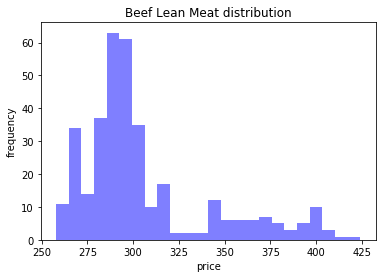

/Users/macbookpro/Desktop/DLSU/9th_Term/DATASCI/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


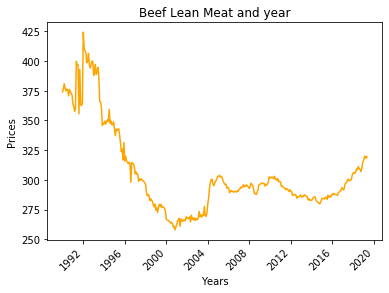

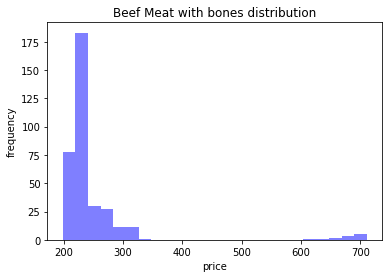

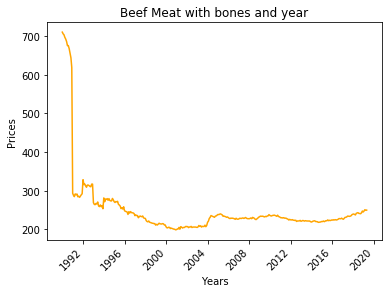

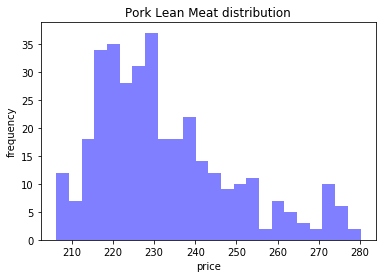

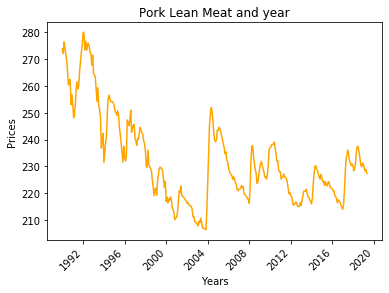

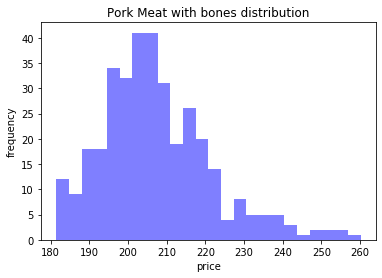

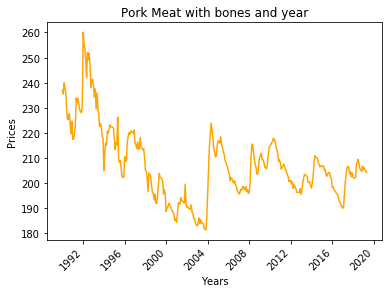

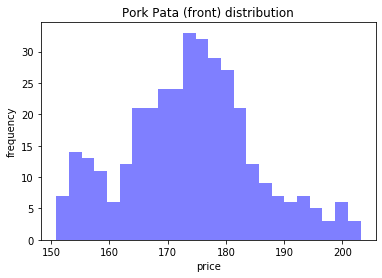

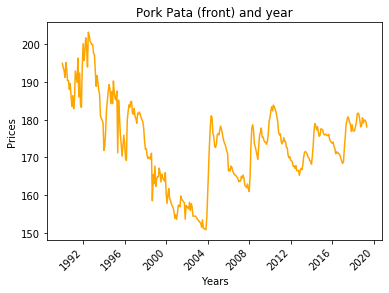

Geolocation                       Commodity  1990 January  1990 February  \
0   PHILIPPINES      Alumahan [Indian mackerel]    168.542452     156.995673   
1   PHILIPPINES               Bangus [Milkfish]    237.012823     240.726699   
2   PHILIPPINES        Bisugo [Threadfin bream]    205.411113     204.094375   
3   PHILIPPINES      Crab, Alimasag [Blue crab]    200.144161     188.394808   
4   PHILIPPINES  Dalagang-Bukid, lapad [Caesio]    215.945016     219.793942   
5   PHILIPPINES               Dilis [Anchovies]    115.872935     109.896971   
6   PHILIPPINES          Galunggong [Roundscad]    147.474645     125.596538   
7   PHILIPPINES              Sapsap [Slipmouth]    158.008548     156.995673   
8   PHILIPPINES  Shrimp, Suaje [Endeavor prawn]    384.487468     366.323237   
9   PHILIPPINES     Shrimp, Sugpo [Tiger prawn]    742.640177     706.480529   
10  PHILIPPINES                         Tilapia    179.076355     183.161619   
11  PHILIPPINES         Tulingan [Frigate tuna]    131.673790     120.363349   

    1990 March  1990 April    1990 May   1990 June   1990 July  1990 August  \
0   156.494089  155.008386  159.167940  157.680389  150.253528   160.270429   
1   239.957604  237.679525  236.184686  244.150280  225.380291   225.380291   
2   193.009377  196.343956  189.974638  193.285639  190.321135   190.321135   
3   198.225847  191.177009  184.840189  188.199174  175.295782   225.380291   
4   213.875256  211.844794  200.243538  208.545031  200.338037   205.346488   
5   104.329393  113.672816  107.823443  116.988676  105.177469   110.185920   
6   140.844681  129.173655  112.957893  116.988676  120.202822   125.211273   
7   151.277620  165.342278  159.167940  157.680389  145.245077   150.253528   
8   375.585815  547.696297  374.814827  371.311885  380.642270   365.616917   
9   678.141054  718.205522  693.150708  712.104984  676.140874   721.216933   
10  166.927029  242.846472  164.302390  162.766854  165.278880   170.287331   
11  114.762332  134.340601  118.092343  127.161604  125.211273   130.219724   

    ...  2018 August  2018 September  2018 October  2018 November  \
0   ...   208.813345      203.740586    197.992487     196.224916   
1   ...   166.414696      170.133891    172.850584     173.139632   
2   ...   273.471284      265.702929    258.752087     269.678094   
3   ...   306.330236      306.661088    305.893155     321.095318   
4   ...   257.571791      255.200837    247.228715     257.086120   
5   ...   121.896115      121.824268    112.090985     112.278428   
6   ...   157.934966      156.481172    153.994157     154.251672   
7   ...   223.652872      219.493724    209.515860     223.507525   
8   ...   410.206926      387.527197    390.747078     390.351171   
9   ...   601.000845      603.870293    587.691987     623.302676   
10  ...   125.076014      122.874477    121.519199     121.722408   
11  ...   154.755068      149.129707    145.613523     146.906355   

    2018 December  2019 January  2019 February  2019 March  2019 April  \
0      202.657696    213.908480     201.978206  194.614417  188.879599   
1      175.214466    179.135181     176.730930  171.471081  172.090301   
2      279.709840    283.455080     280.875943  272.460184  271.776756   
3      338.818335    346.679261     329.266555  326.110645  327.391304   
4      273.376787    269.756507     269.304275  269.304275  258.135452   
5      121.383516    132.770781     127.288349  126.236379  123.821070   
6      158.326325    164.382872     156.743504  148.327745  147.955686   
7      220.601346    227.607053     229.329422  221.965633  218.260870   
8      407.426409    425.709488     403.956412  408.164292  412.387124   
9      652.304458    668.068850     663.792959  651.169321  647.437291   
10     121.383516    121.179681     123.080469  122.028500  124.870401   
11     151.993272    160.167926     155.691534  150.431685  149.005017   

      2019 May  
0   189.611853  
1   171.803005  
2   270.275459  
3   32

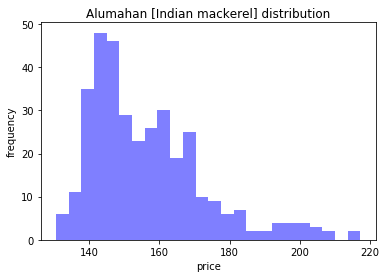

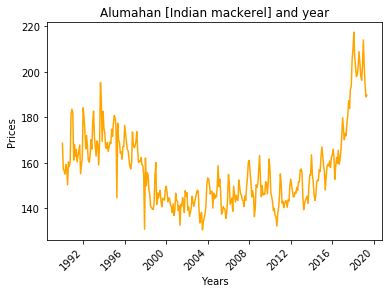

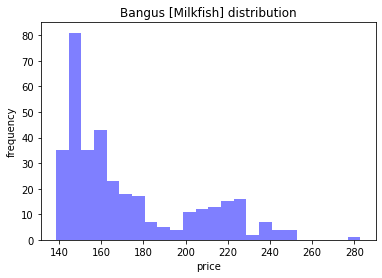

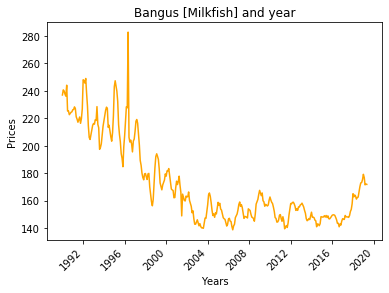

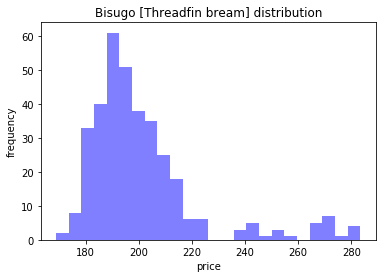

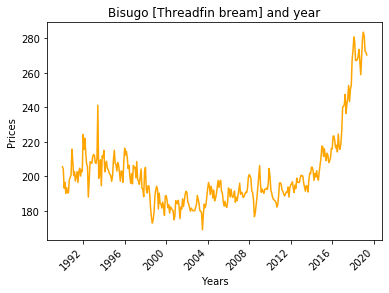

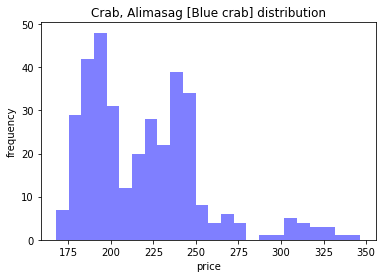

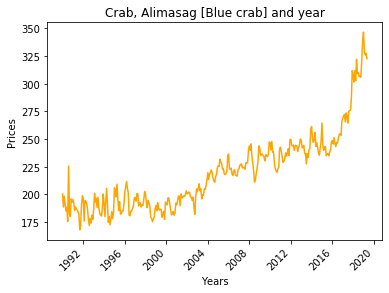

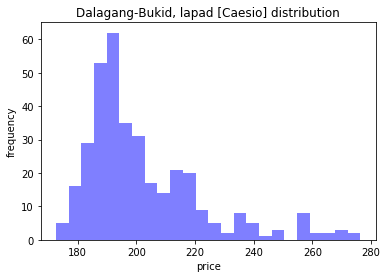

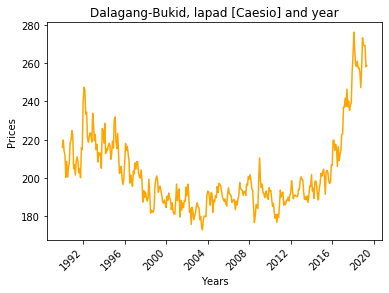

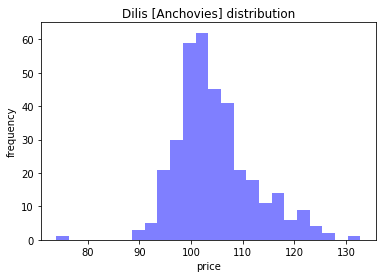

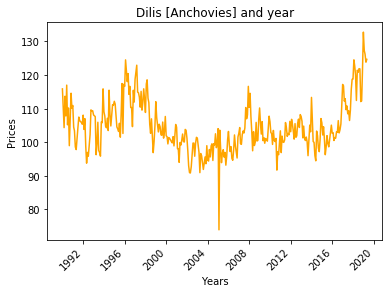

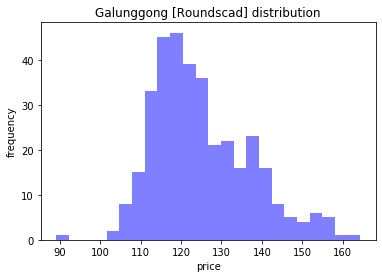

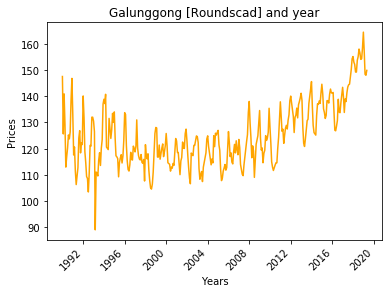

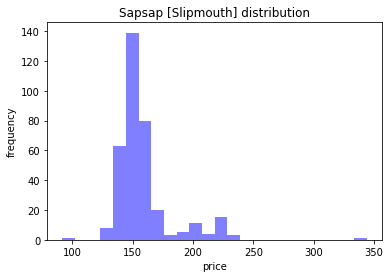

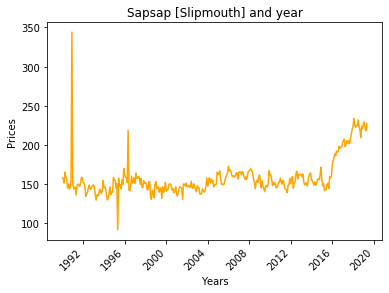

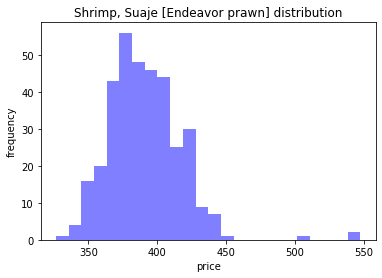

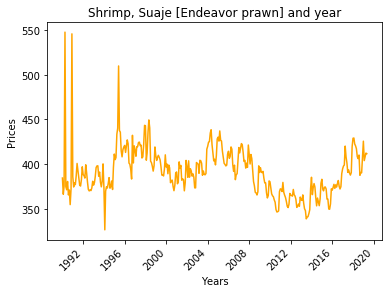

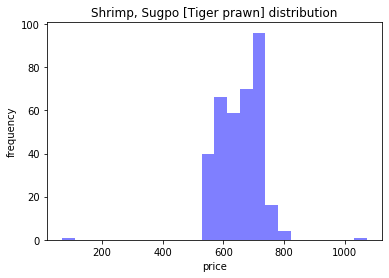

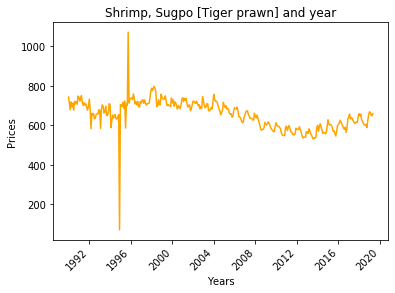

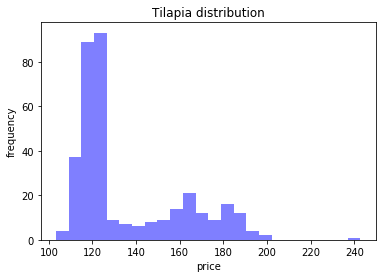

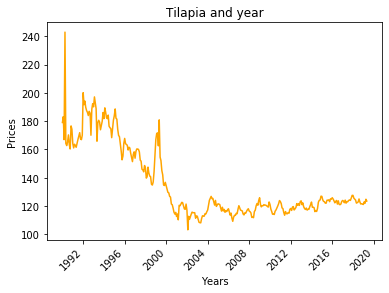

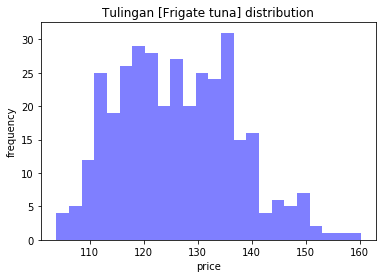

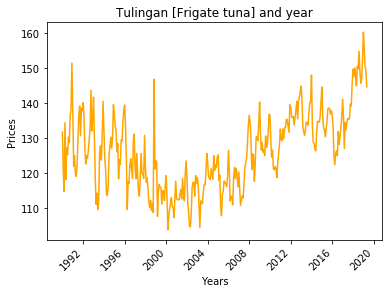

Geolocation                        Commodity  1990 January  1990 February  \
0  PHILIPPINES  Chicken Fully Dressed (broiler)    279.148435     266.892644   
1  PHILIPPINES           Chicken Broiler (live)    231.745871     230.260321   
2  PHILIPPINES       Chicken egg (other breed)*      5.266952       5.233189   
3  PHILIPPINES                        Duck egg*     10.533903      10.466378   

   1990 March  1990 April    1990 May   1990 June   1990 July  1990 August  \
0  266.039952  268.681203  277.260283  269.582601  265.447899   270.456350   
1  224.308195  232.512579  225.915786  218.717960  200.338037   220.371840   
2    5.216470    5.166946    5.134450    5.086464    5.008451     5.008451   
3   10.432939   10.333892    5.134450   10.172928   10.016902    10.016902   

   ...  2018 August  2018 September  2018 October  2018 November  \
0  ...   164.294764      161.732218    160.279633     159.498328   
1  ...   146.275338      144.928870    143.518364     142.709030   
2  ...     5.299831        5.251046      5.237896       5.246656   
3  ...     8.479730        8.401674      8.380634       8.394649   

   2018 December  2019 January  2019 February  2019 March  2019 April  \
0     161.492851    157.006717     155.691534  155.691534  155.301003   
1     144.604710    134.878254     128.340319  130.444258  129.067726   
2       5.277544      5.268682       5.259849    5.259849    5.246656   
3       8.444071      8.429891       8.415759    8.415759    8.394649   

     2019 May  
0  155.041736  
1  129.899833  
2    5.237896  
3    8.380634  

[4 rows x 355 columns]

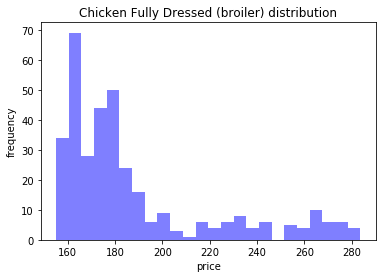

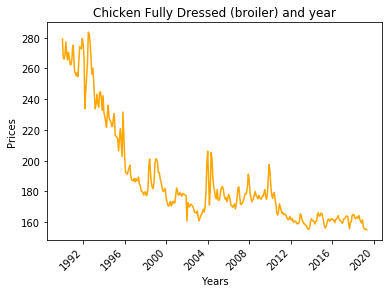

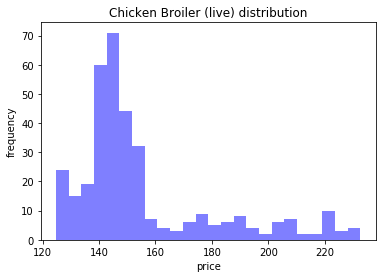

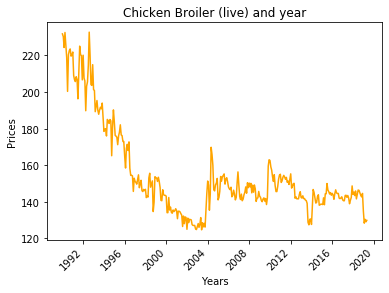

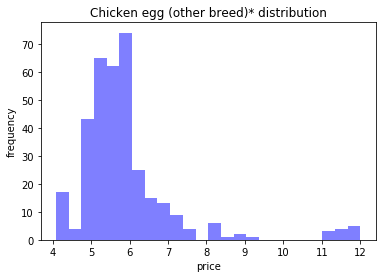

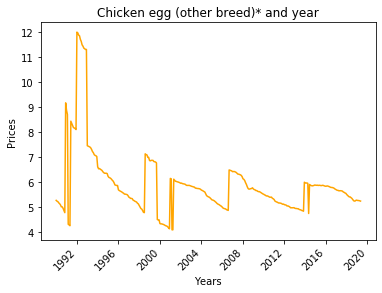

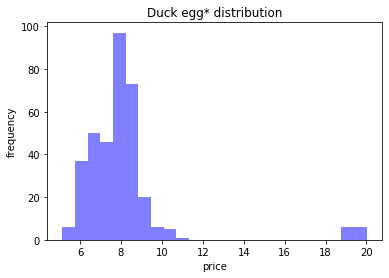

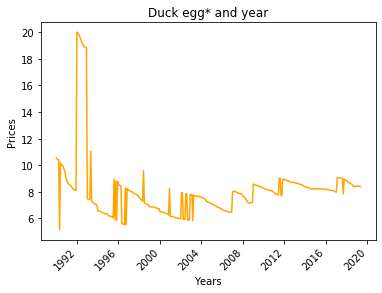

Geolocation                                 Commodity  1990 January  \
0   PHILIPPINES                                   Carrots    110.605984   
1   PHILIPPINES  Gabi Cebu, for ginataan [Taro (cocoyam)]     36.868661   
2   PHILIPPINES                              Sweet Potato     15.800855   
3   PHILIPPINES                        White/Irish Potato    100.072081   
4   PHILIPPINES                   Ampalaya [Bitter gourd]     63.203419   
5   PHILIPPINES                                   Chayote     31.601710   
6   PHILIPPINES                     Eggplant long, purple     52.669516   
7   PHILIPPINES                                    Squash     36.868661   
8   PHILIPPINES                                    Tomato     47.402565   
9   PHILIPPINES                        Upo [Bottle gourd]     26.334758   
10  PHILIPPINES                                   Cabbage     63.203419   
11  PHILIPPINES           Camote tops [Sweet potato tops]     21.067806   
12  PHILIPPINES                  Kangkong [Morning glory]     21.067806   
13  PHILIPPINES                             Pechay native     36.868661   
14  PHILIPPINES                 Habitchuelas [Snap beans]     73.737323   
15  PHILIPPINES                   Mongo [Mungbean], green    110.605984   
16  PHILIPPINES                    Peanut with shell, dry     89.538177   
17  PHILIPPINES                 Peanut without shell, dry    316.017097   
18  PHILIPPINES                               Stringbeans     52.669516   
19  PHILIPPINES                                    Garlic    584.631629   
20  PHILIPPINES                           Ginger Hawaiian     63.203419   
21  PHILIPPINES            Onion Red Creole (Bermuda red)    115.872935   
22  PHILIPPINES               Onion White (Yellow granex)     89.538177   
23  PHILIPPINES                              Rice Special    189.610258   
24  PHILIPPINES                              Rice Premium    168.542452   
25  PHILIPPINES                    Well Milled Rice (WMR)     47.402565   
26  PHILIPPINES                 Regular Milled Rice (RMR)     42.135613   
27  PHILIPPINES                          Corngrain Yellow     36.868661   
28  PHILIPPINES                           Corngrain White     31.601710   
29  PHILIPPINES                          Corngrits Yellow     36.868661   
30  PHILIPPINES                           Corngrits White     36.868661   
31  PHILIPPINES                     Banana Lakatan, ripe*      0.000000   
32  PHILIPPINES                    Banana Latundan, ripe*      0.000000   
33  PHILIPPINES                        Banana Saba, ripe*      0.000000   
34  PHILIPPINES                                 Calamansi     73.737323   
35  PHILIPPINES                          Mandarin Szinkom     89.538177   
36  PHILIPPINES                       Mango Carabao, ripe    168.542452   
37  PHILIPPINES                          Mango Piko, ripe    110.605984   
38  PHILIPPINES                          Papaya Hawaiian*     63.203419   
39  PHILIPPINES                       Pineapple Hawaiian*     47.402565   

    1990 February  1990 March  1990 April    1990 May   1990 June   1990 July  \
0       88.964215   93.896454  103.338924  133.495692  172.939782  210.354939   
1       41.865513   41.731757  113.672816  112.957893   50.864642   50.084509   
2       15.699567   26.082348   25.834731   25.672248   30.518785   30.050706   
3       83.731026   83.463514   51.669462   82.151195   81.383427  100.169018   
4       57.565080   52.164696   51.669462   56.478947   66.124034   70.118313   
5       31.399135   31.298818   31.001677   35.941148   40.691713   40.067607   
6       47.098702   41.731757   46.502516   46.210047   45.778178   55.092960   
7       36.632324   31.298818   31.001677   35.941148   35.605249   40.067607   
8       31.399135   31.298818   31.001677   41.075597   66.124034   60.101411   
9       26.165946   26.082348   25.834731   25.672248   30.518785   35.059156   
10      57.565080   73.030575   93.00

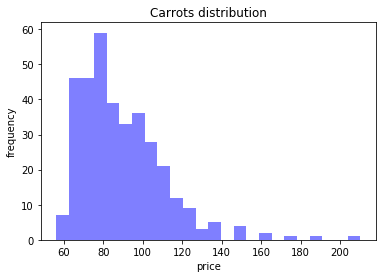

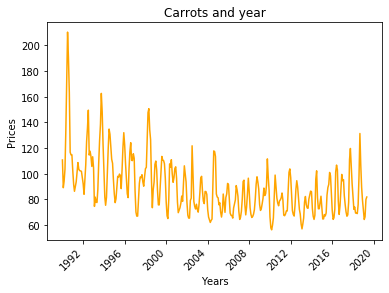

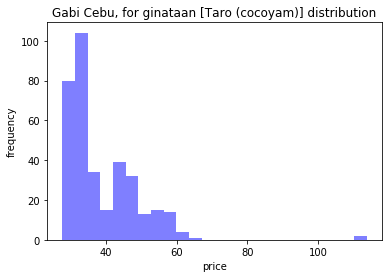

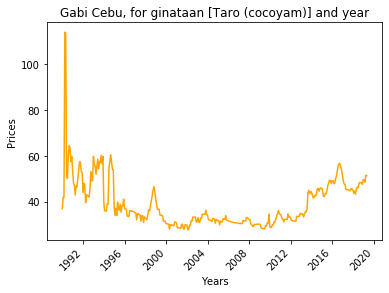

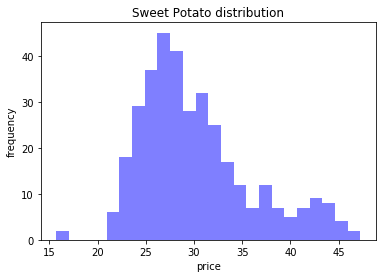

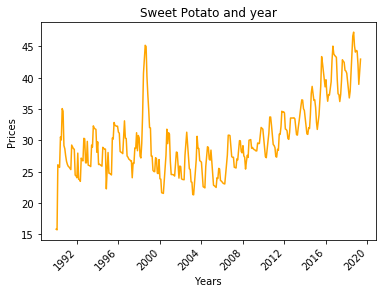

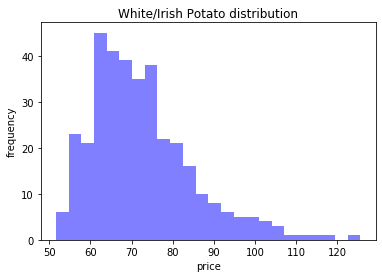

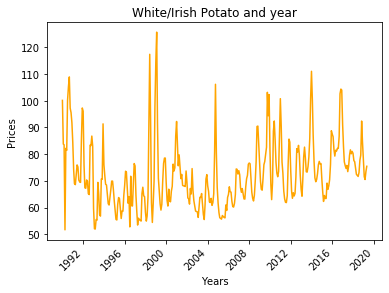

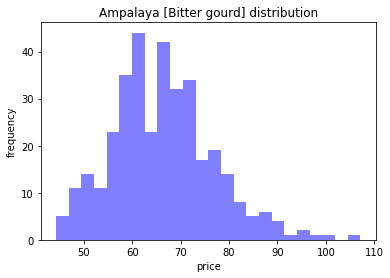

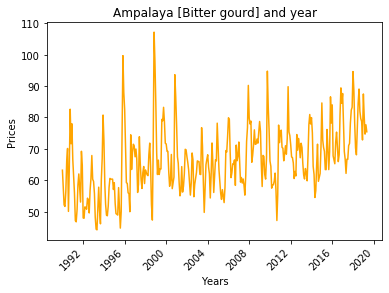

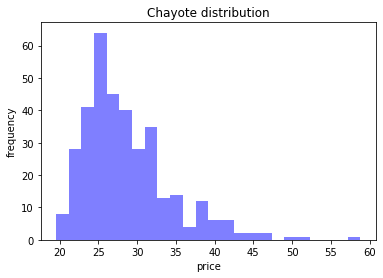

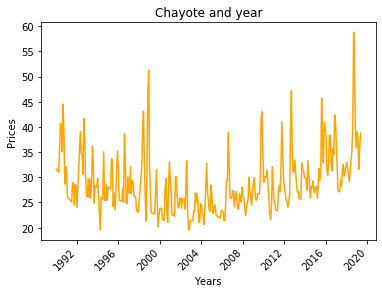

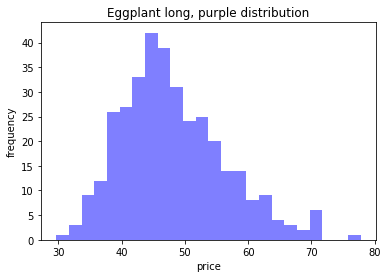

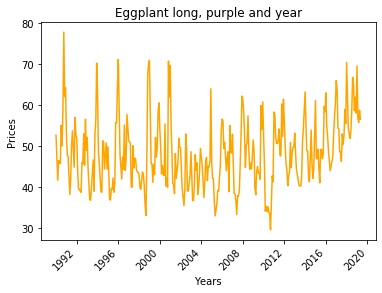

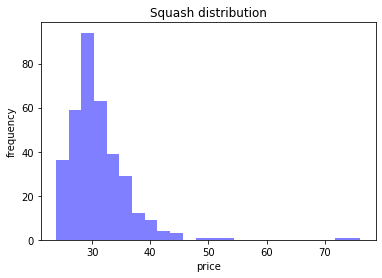

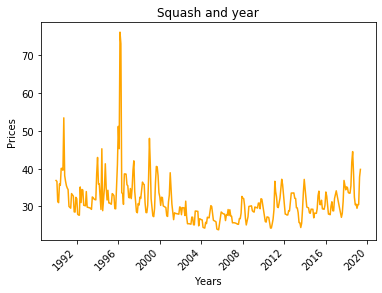

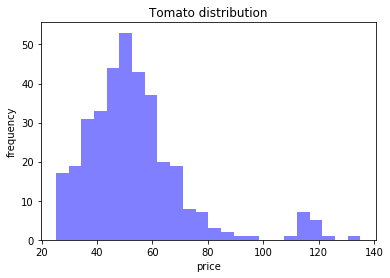

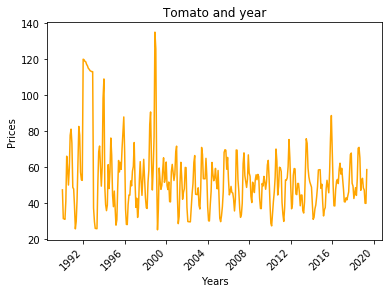

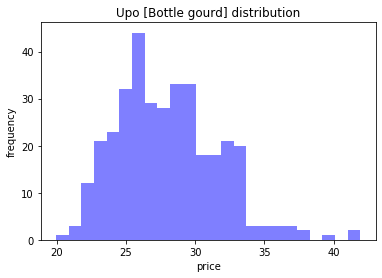

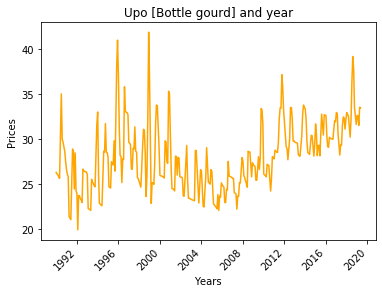

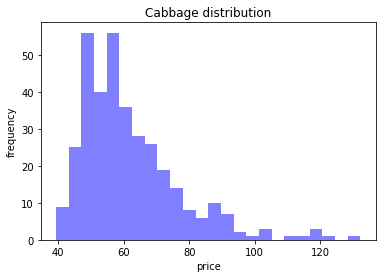

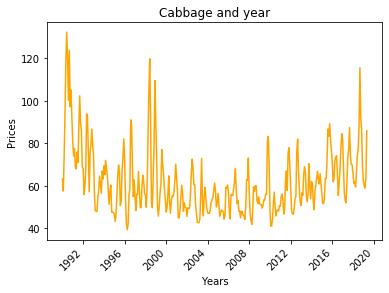

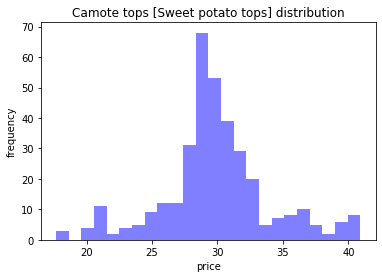

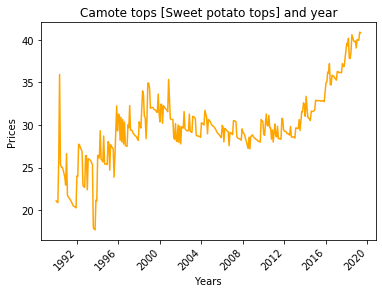

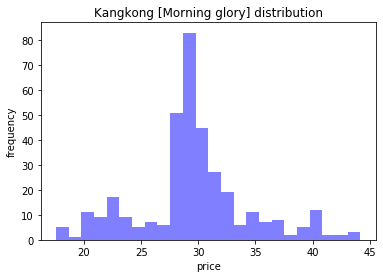

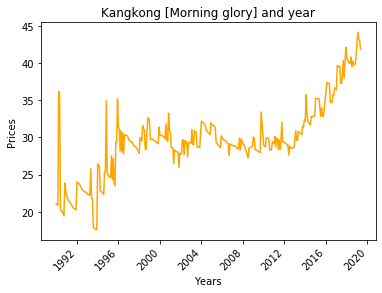

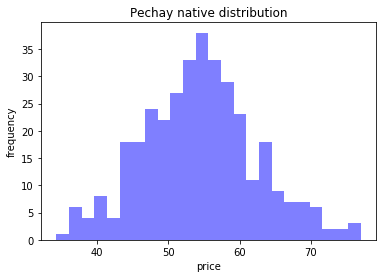

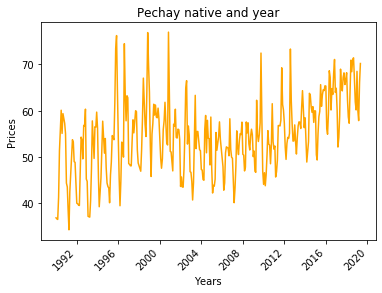

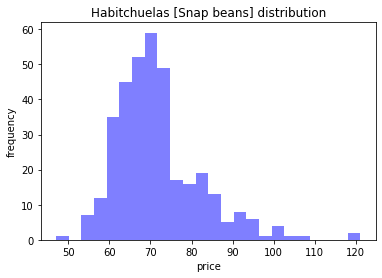

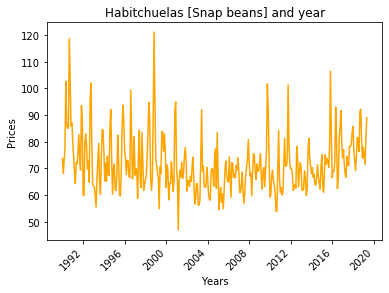

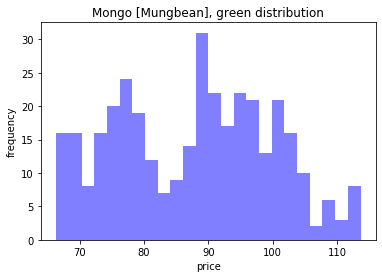

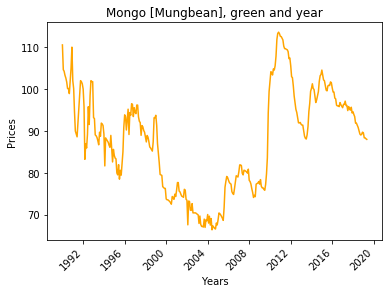

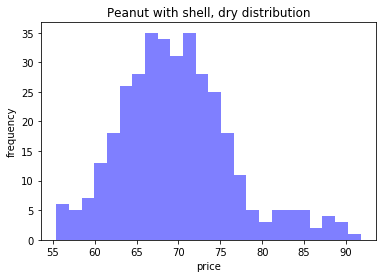

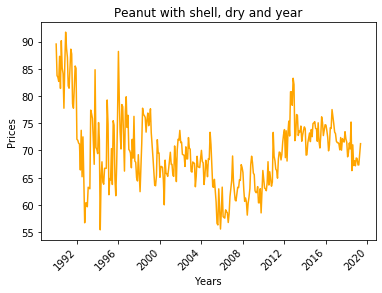

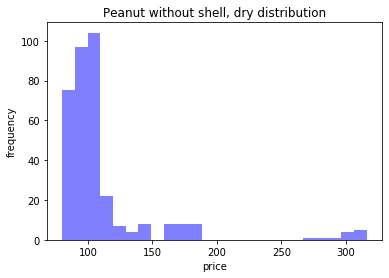

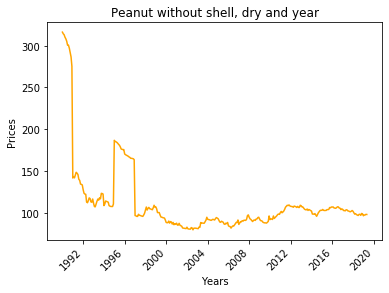

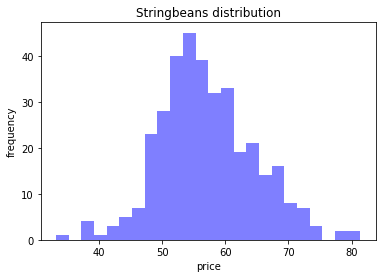

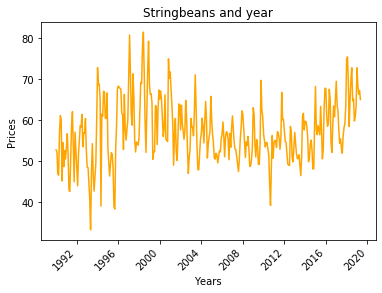

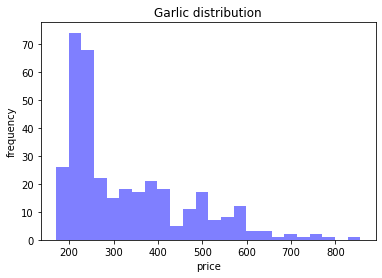

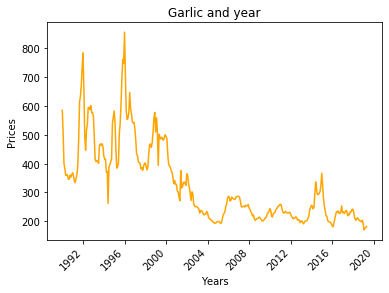

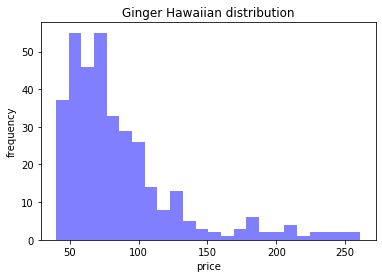

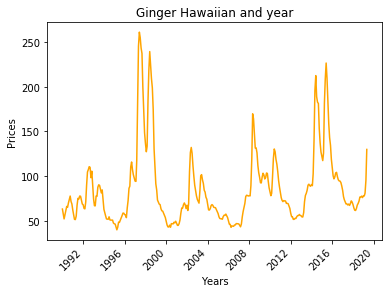

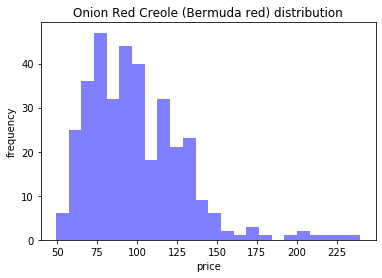

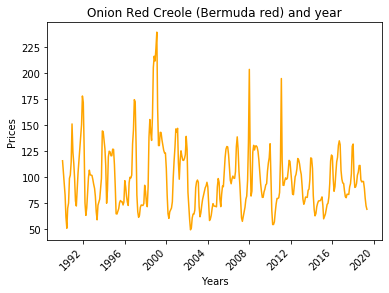

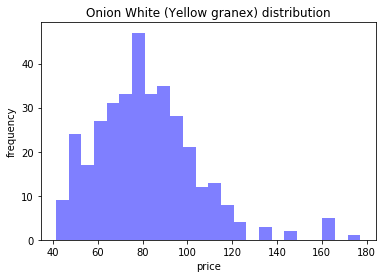

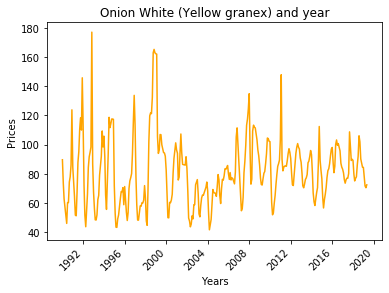

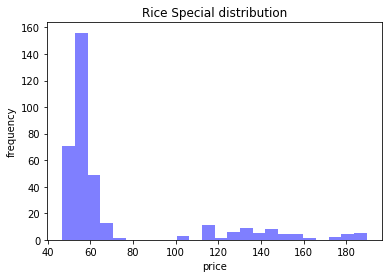

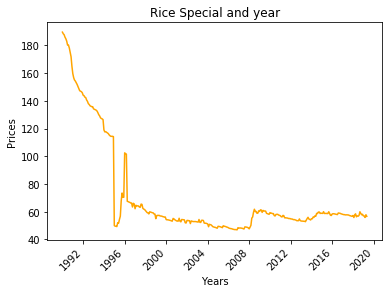

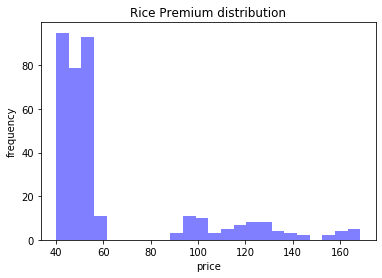

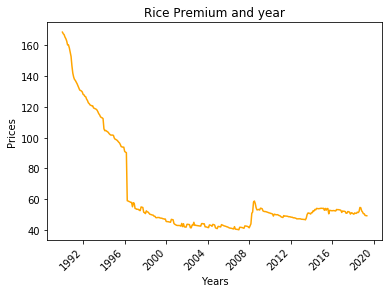

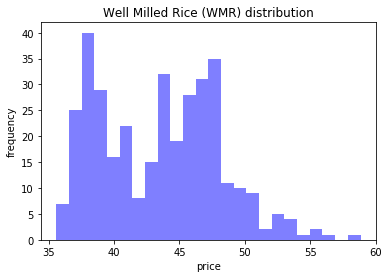

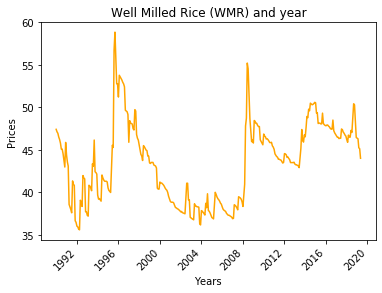

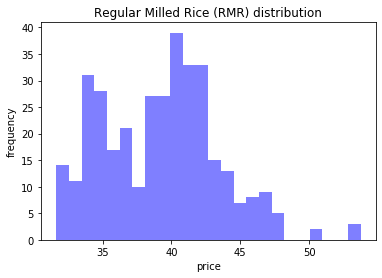

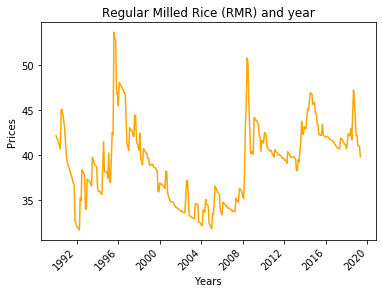

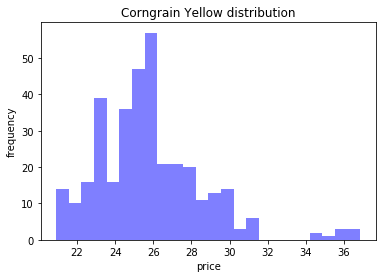

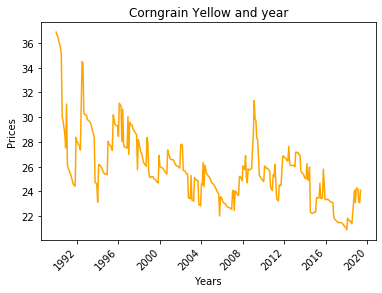

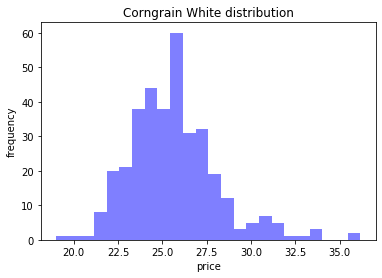

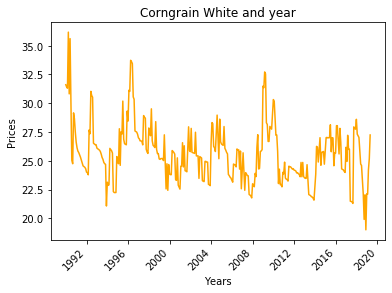

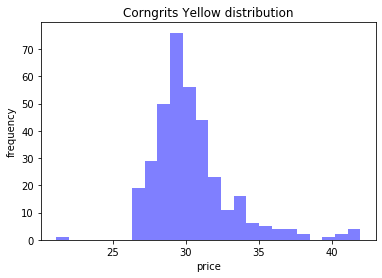

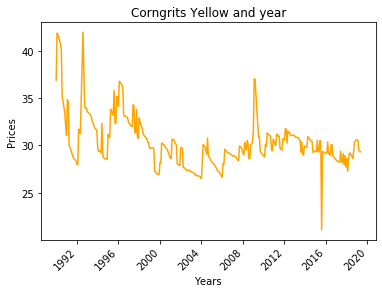

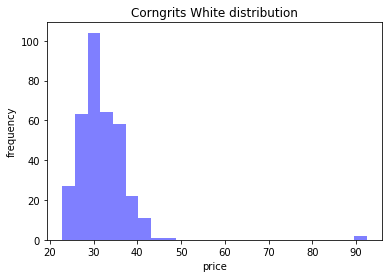

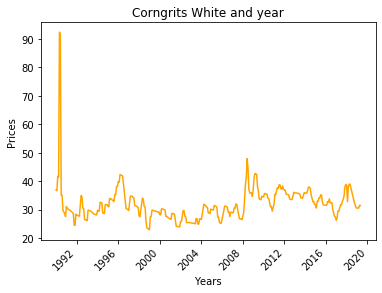

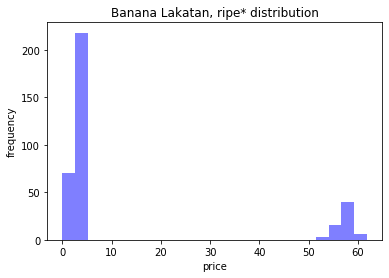

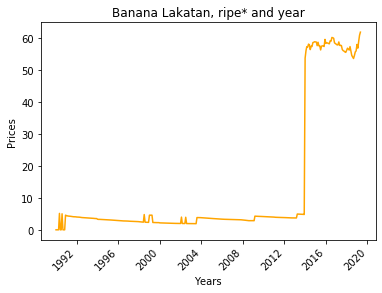

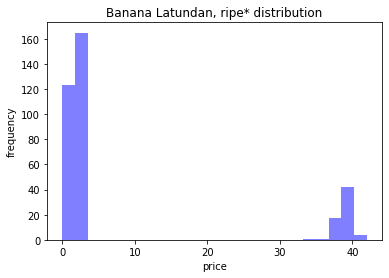

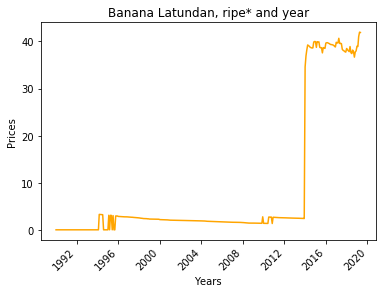

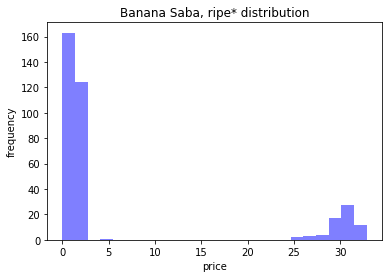

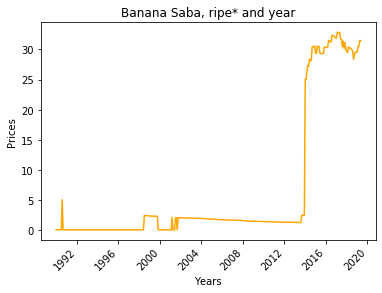

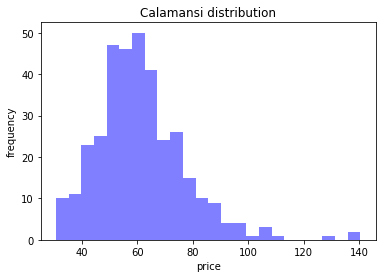

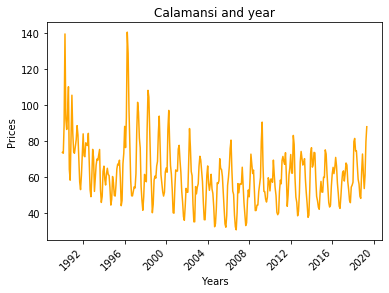

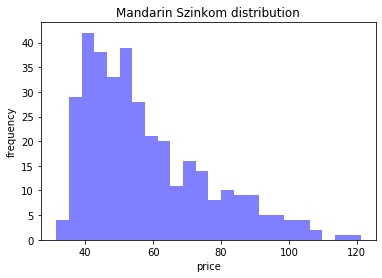

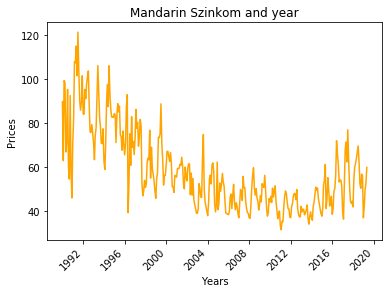

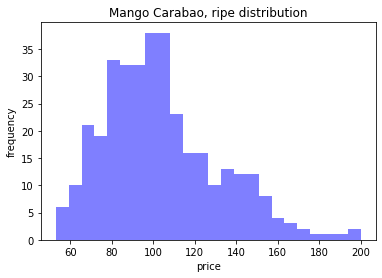

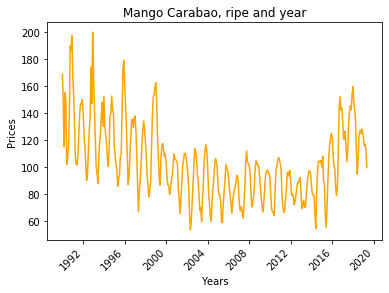

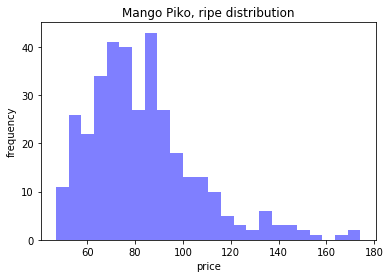

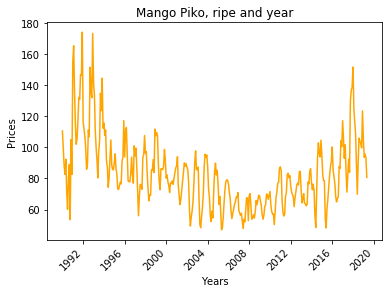

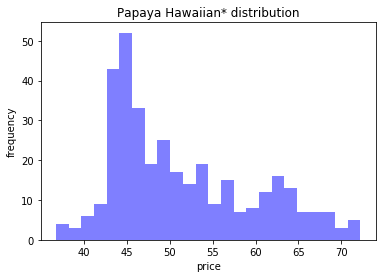

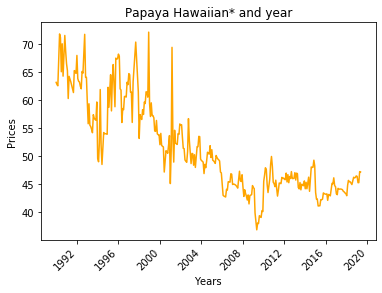

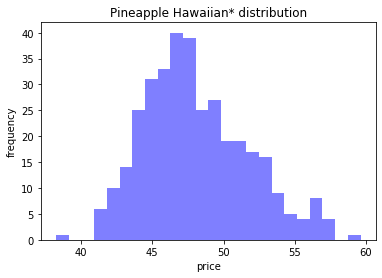

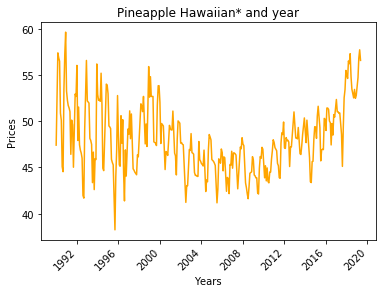

In [26]:
geofiles = [f for f in listdir(geofolder) if isfile(join(geofolder, f))]
national_cpi =[]
for x in geofiles:
    if 'CPI' in x and x != '.DS_Store':
        national_cpi.append(x)
        
def histo_graph():
    for file in national_cpi:
        province = pd.read_csv(DSDATA / 'FOOD_BY_GEO' / file , encoding = "ISO-8859-1")
        display(province)
        #province = normaliser(province)
        #hist = province.hist(bins=10000,histtype='step')
        num_bins = 24
        #date = list(province.columns[2:]).astype('datetime64[ns]') 
        for x in range(province.shape[0]):
            n, bins, patches = plt.hist(province.iloc[x,2:].astype(float), num_bins, facecolor='blue', alpha=0.5)
            plt.xlabel('price')
            plt.ylabel('frequency')
            plt.title( province.iloc[x,1] +' distribution')
            plt.show()
            years = pd.to_datetime(pd.Series(list(province.columns[2:])), format='%Y %B')
            plt.plot(years,province.iloc[x,2:], color='orange')
            plt.xlabel('Years')
            plt.ylabel('Prices')
            plt.xticks(rotation=45, ha='right')
            plt.title( province.iloc[x,1]+' and year')
            plt.show()

histo_graph()   

# unprocessed

Geolocation                       Commodity  1990 January  1990 February  \
0   PHILIPPINES      Alumahan [Indian mackerel]         32.68          30.07   
1   PHILIPPINES               Bangus [Milkfish]         45.47          46.16   
2   PHILIPPINES        Bisugo [Threadfin bream]         39.03          39.34   
3   PHILIPPINES      Crab, Alimasag [Blue crab]         38.08          36.00   
4   PHILIPPINES  Dalagang-Bukid, lapad [Caesio]         41.25          42.48   
5   PHILIPPINES               Dilis [Anchovies]         22.02          21.53   
6   PHILIPPINES          Galunggong [Roundscad]         28.35          24.86   
7   PHILIPPINES              Sapsap [Slipmouth]         30.49          30.70   
8   PHILIPPINES  Shrimp, Suaje [Endeavor prawn]         73.80          70.73   
9   PHILIPPINES     Shrimp, Sugpo [Tiger prawn]        141.35         135.42   
10  PHILIPPINES                         Tilapia         34.51          35.19   
11  PHILIPPINES         Tulingan [Frigate tuna]         25.37          23.63   

    1990 March  1990 April  1990 May  1990 June  1990 July  1990 August  ...  \
0        30.36       30.32     31.96      31.30      30.93        32.15  ...   
1        46.35       46.87     46.80      48.31      45.57        45.44  ...   
2        37.42       38.33     37.57      38.38      38.39        38.52  ...   
3        38.00       37.56     36.47      37.15      35.81        45.51  ...   
4        41.25       41.95     39.61      41.50      40.97        41.25  ...   
5        20.24       22.34     21.50      23.16      21.84        22.50  ...   
6        27.05       25.96     22.84      23.30      24.54        25.50  ...   
7        29.90       32.37     31.09      31.92      29.71        30.86  ...   
8        72.04      106.85     73.37      73.74      76.31        73.44  ...   
9       130.86      139.77    135.09     140.22     135.03       144.35  ...   
10       32.21       47.98     32.51      32.81      33.98        34.52  ...   
11       22.55       26.87     23.78      25.18      25.06        26.58  ...   

    2018 September  2018 October  2018 November  2018 December  2018 Annual  \
0           194.71        189.50         187.58         192.15       190.43   
1           162.34        165.06         165.60         166.36       156.18   
2           253.32        247.50         257.44         265.54       253.30   
3           292.24        292.33         306.20         321.96       292.37   
4           243.21        236.22         245.38         259.50       243.86   
5           116.56        107.00         107.66         115.41       111.47   
6           149.59        147.20         147.52         150.34       144.22   
7           209.21        200.04         213.48         209.02       208.87   
8           369.73        373.15         372.31         386.27       382.82   
9           575.45        561.45         594.82         618.65       583.64   
10          117.94        116.35         116.23         115.25       115.92   
11          142.88        139.31         140.41         144.99       139.57   

    2019 January  2019 February  2019 March  2019 April  2019 May  
0         203.98         192.44      185.30      180.60    181.08  
1         170.69         168.97      163.85      164.11    164.37  
2         269.08         267.90      259.63      259.22    258.91  
3         329.93         313.69      310.73      312.47    308.33  
4         256.52         256.64      256.36      246.37    247.91  
5         126.16         121.06      120.87      118.64    119.22  
6         156.70         149.58      141.36      141.58    143.40  
7         216.48         218.90      211.86      208.17    217.66  
8         404.95         384.54      388.73      393.94    393.30  
9         634.45         631.80      619.05      617.67    629.47  
10        115.72         117.23      116.86      119.27    118.47  
11        152.93         148.90      143.93      142.76    138.49  

[12 rows 

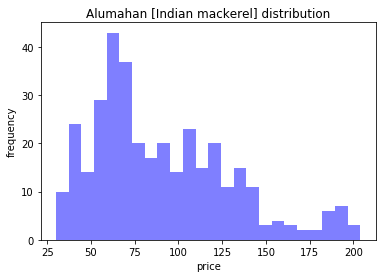

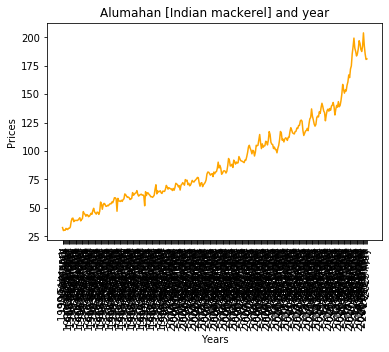

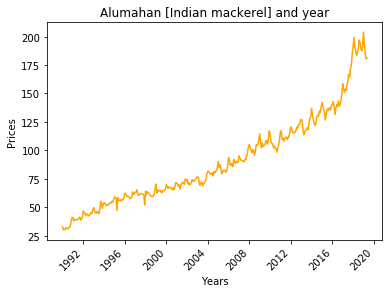

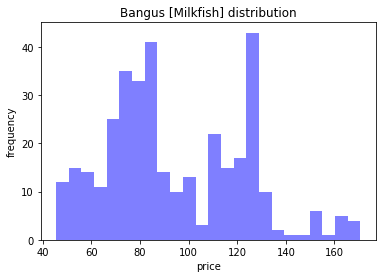

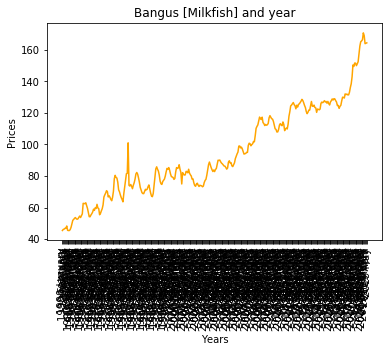

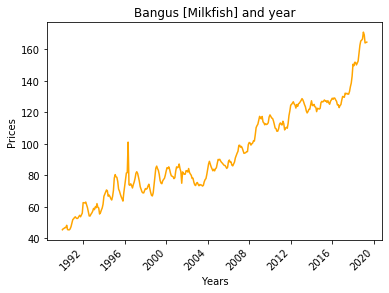

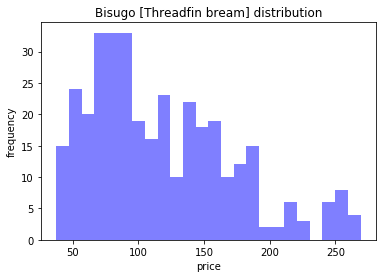

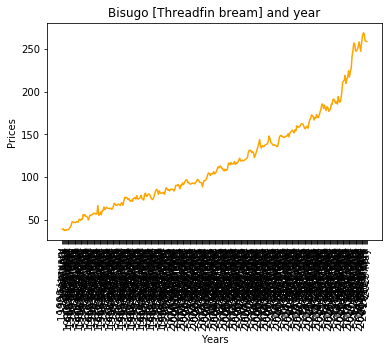

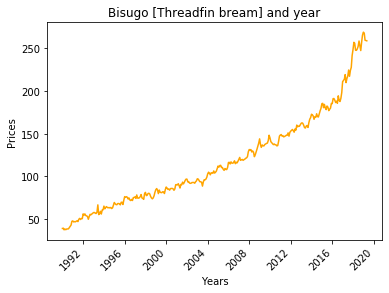

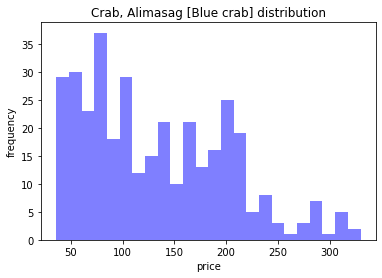

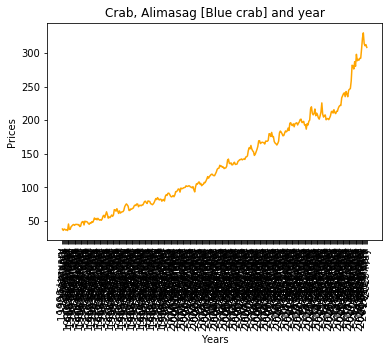

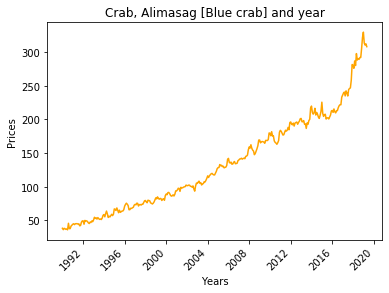

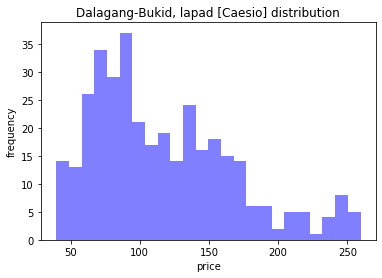

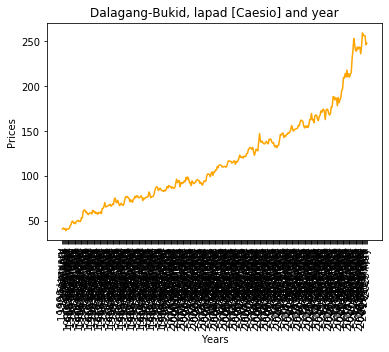

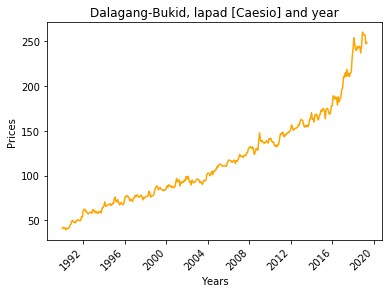

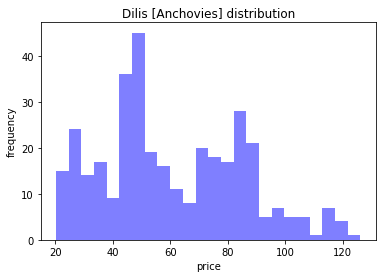

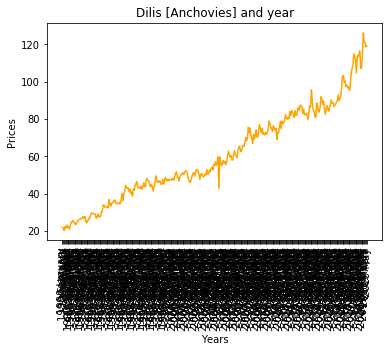

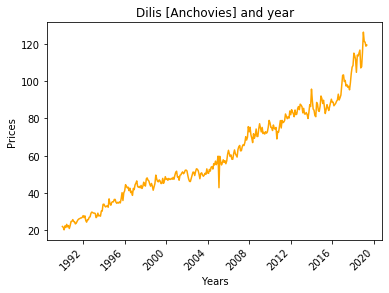

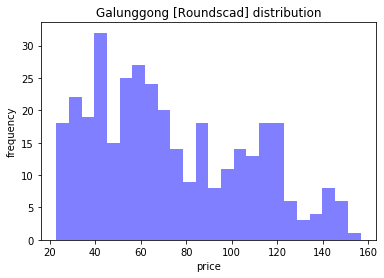

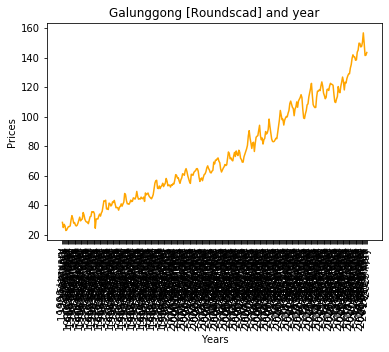

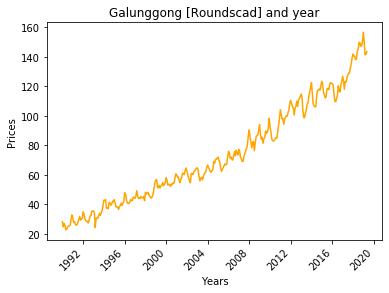

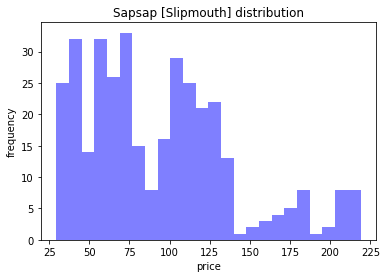

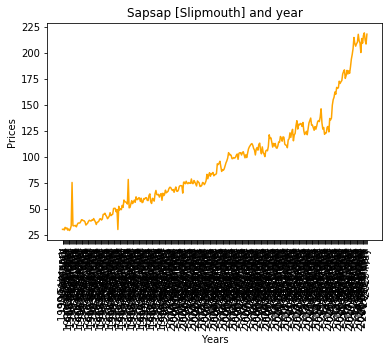

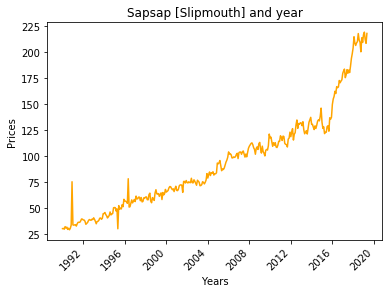

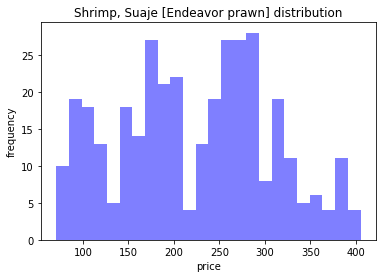

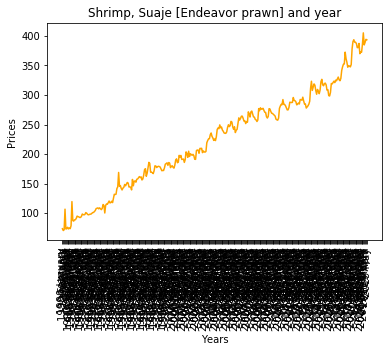

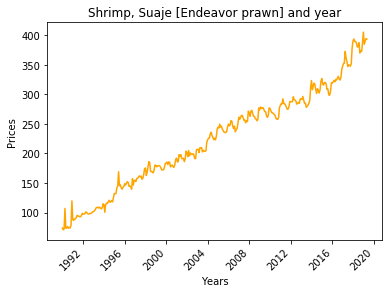

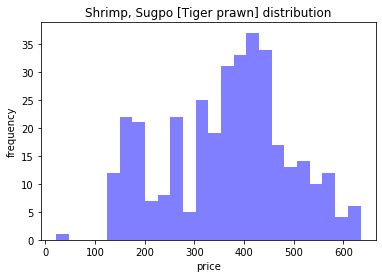

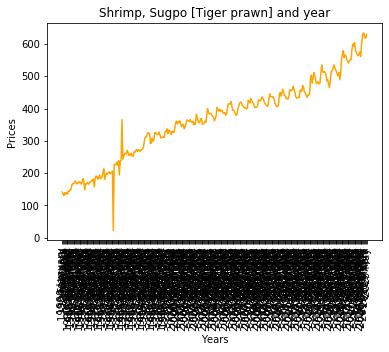

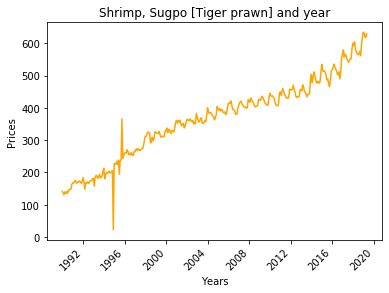

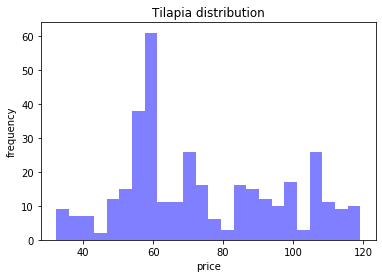

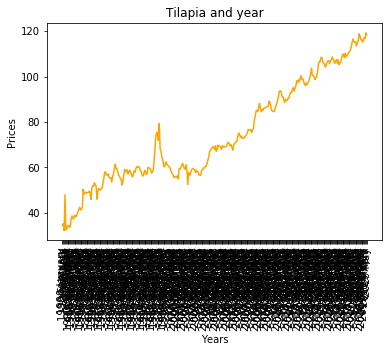

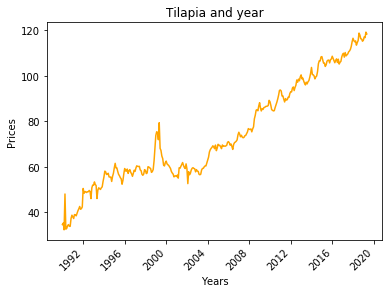

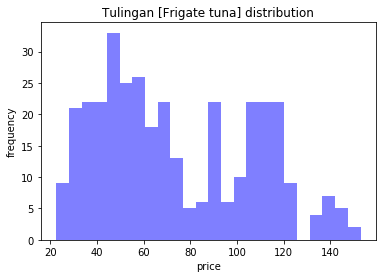

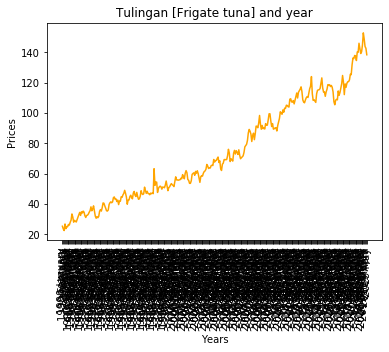

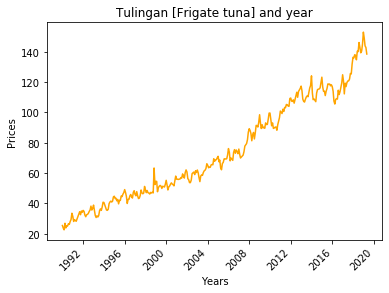

Geolocation                        Commodity  1990 January  1990 February  \
0  PHILIPPINES  Chicken Fully Dressed (broiler)         53.07          51.27   
1  PHILIPPINES           Chicken Broiler (live)         44.42          44.16   
2  PHILIPPINES       Chicken egg (other breed)*          1.77           1.74   
3  PHILIPPINES                        Duck egg*          2.20           2.16   

   1990 March  1990 April  1990 May  1990 June  1990 July  1990 August  ...  \
0       51.91       52.82     54.15      53.01      53.38        54.72  ...   
1       43.41       45.00     44.14      43.35      40.94        44.83  ...   
2        1.64        1.58      1.59       1.64       1.74         1.81  ...   
3        2.15        2.10      1.99       2.06       2.10         2.17  ...   

   2018 September  2018 October  2018 November  2018 December  2018 Annual  \
0          154.19        153.24         152.92         153.01       152.31   
1          138.78        137.41         136.32         137.79       135.40   
2            5.78          5.82           5.83           5.84         5.74   
3            8.39          8.33           8.39           8.31         8.30   

   2019 January  2019 February  2019 March  2019 April  2019 May  
0        149.26         148.50      148.86      148.20    148.64  
1        128.20         122.97      124.97      123.67    124.09  
2          5.77           5.82        5.83        5.80      5.75  
3          8.38           8.48        8.32        8.50      8.50  

[4 rows x 384 columns]

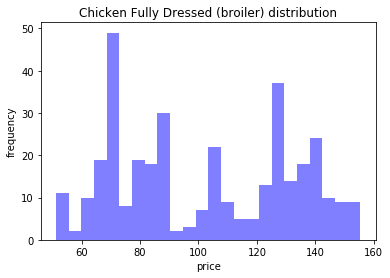

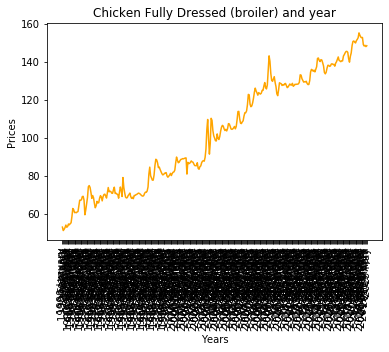

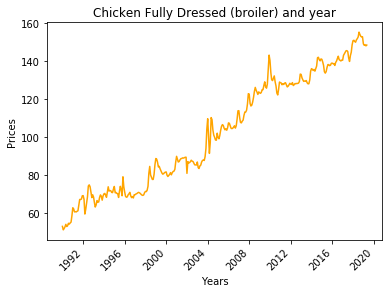

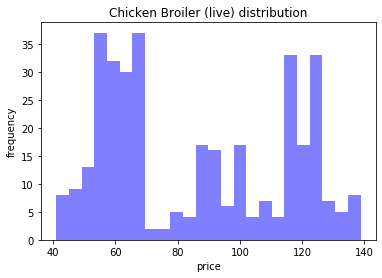

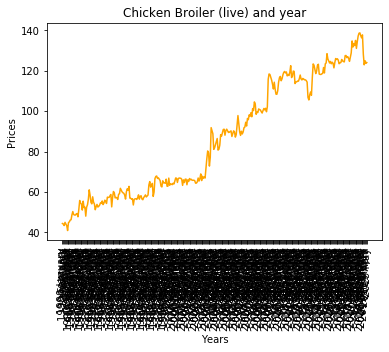

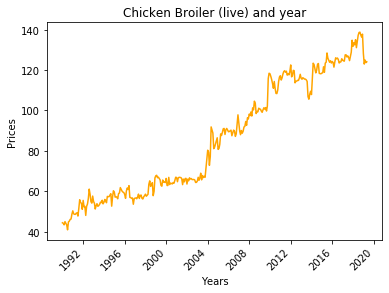

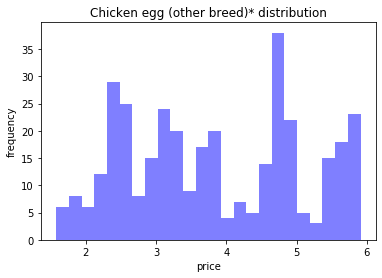

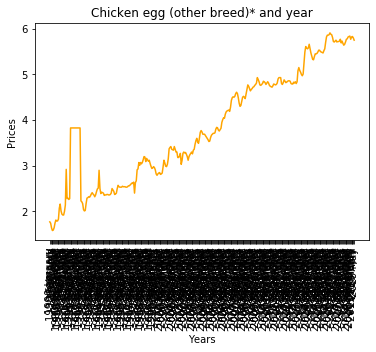

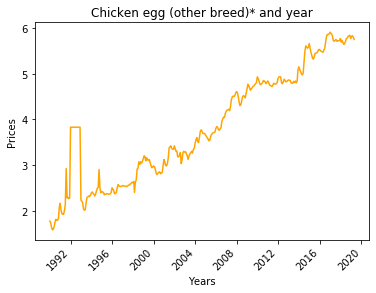

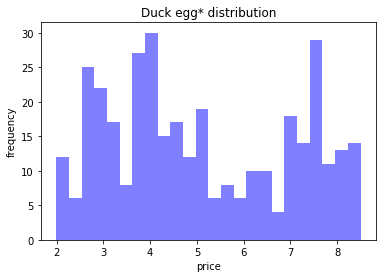

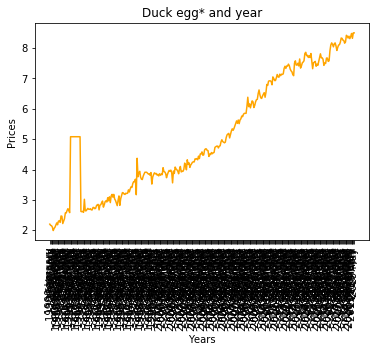

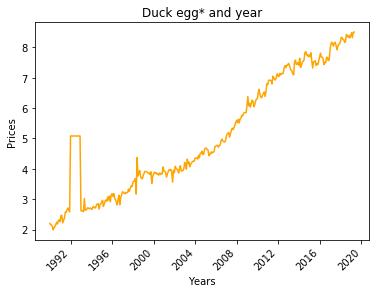

Geolocation             Commodity  1990 January  1990 February  1990 March  \
0  PHILIPPINES        Beef Lean Meat     71.060000      72.220000   73.140000   
1  PHILIPPINES  Beef Meat with bones    135.298076     135.298076  135.298076   
2  PHILIPPINES        Pork Lean Meat     52.270000      52.630000   53.180000   
3  PHILIPPINES  Pork Meat with bones     45.260000      45.360000   46.100000   
4  PHILIPPINES     Pork Pata (front)     37.640000      37.800000   37.640000   

   1990 April    1990 May   1990 June   1990 July  1990 August  ...  \
0   73.740000   73.880000   74.200000   75.400000    74.750000  ...   
1  135.298076  135.298076  135.298076  135.298076   135.298076  ...   
2   53.160000   53.140000   53.230000   53.180000    52.860000  ...   
3   46.480000   46.010000   45.610000   45.280000    45.300000  ...   
4   37.860000   38.900000   38.580000   38.690000    38.500000  ...   

   2018 September  2018 October  2018 November  2018 December  2018 Annual  \
0          294.33        293.85         295.17         298.39       288.73   
1          229.05        229.57         231.56         234.01       225.37   
2          222.29        220.47         219.50         219.82       217.63   
3          196.66        196.35         195.55         196.64       192.37   
4          171.40        170.28         170.76         171.12       167.81   

   2019 January  2019 February  2019 March  2019 April  2019 May  
0        300.22         303.06      304.25      303.17    305.24  
1        232.96         235.21      238.87      237.32    238.87  
2        219.21         218.87      217.64      218.18    217.85  
3        195.58         196.07      195.65      195.84    195.57  
4        170.49         171.72      171.26      171.03    170.09  

[5 rows x 384 columns]

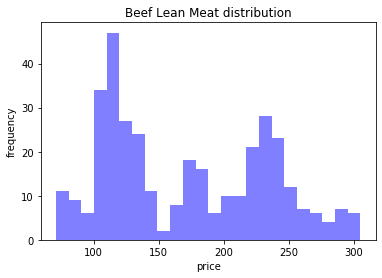

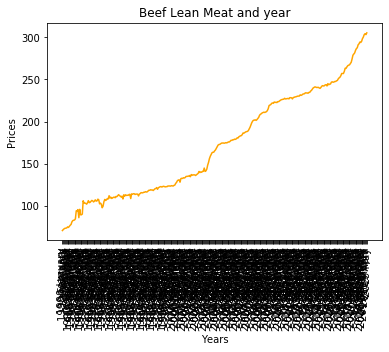

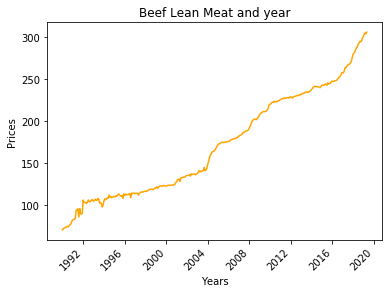

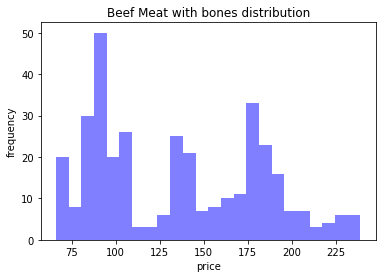

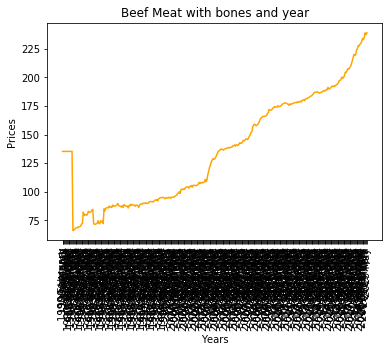

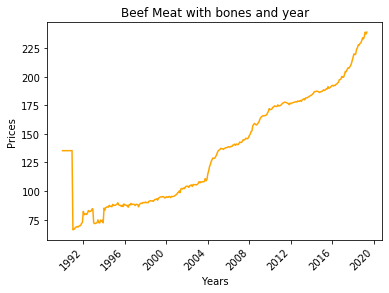

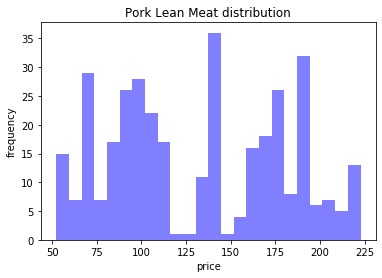

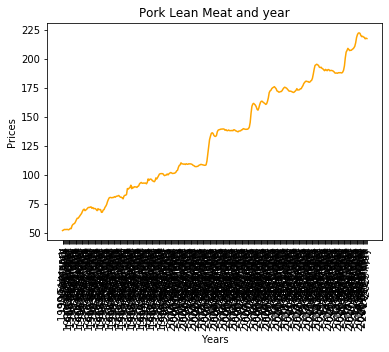

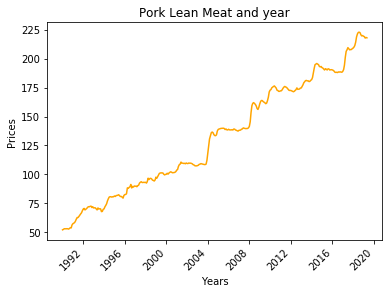

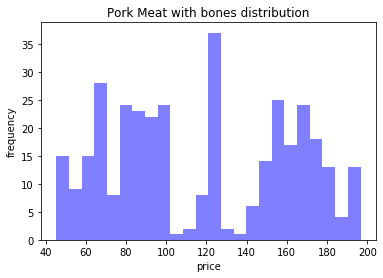

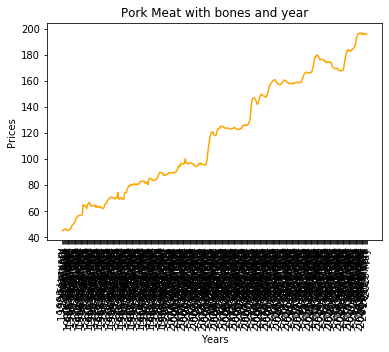

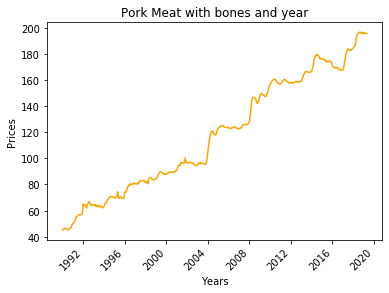

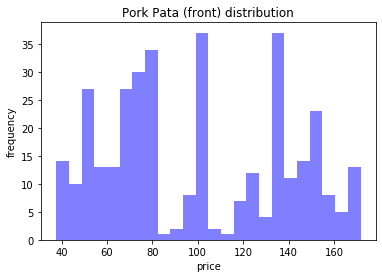

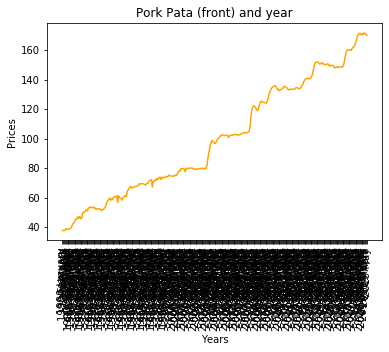

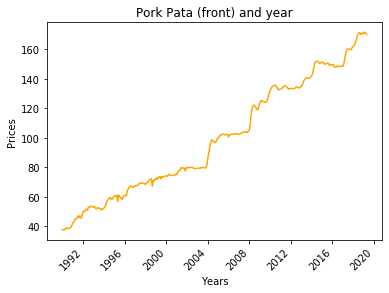

Geolocation                                 Commodity  1990 January  \
0   PHILIPPINES                                   Carrots     21.320000   
1   PHILIPPINES  Gabi Cebu, for ginataan [Taro (cocoyam)]      7.870000   
2   PHILIPPINES                              Sweet Potato      3.660000   
3   PHILIPPINES                        White/Irish Potato     19.490000   
4   PHILIPPINES                   Ampalaya [Bitter gourd]     12.890000   
5   PHILIPPINES                                   Chayote      6.070000   
6   PHILIPPINES                     Eggplant long, purple     10.910000   
7   PHILIPPINES                                    Squash      7.260000   
8   PHILIPPINES                                    Tomato      9.250000   
9   PHILIPPINES                        Upo [Bottle gourd]      5.760000   
10  PHILIPPINES                                   Cabbage     12.260000   
11  PHILIPPINES           Camote tops [Sweet potato tops]      4.420000   
12  PHILIPPINES                  Kangkong [Morning glory]      4.120000   
13  PHILIPPINES                             Pechay native      7.560000   
14  PHILIPPINES                 Habitchuelas [Snap beans]     14.730000   
15  PHILIPPINES                   Mongo [Mungbean], green     21.060000   
16  PHILIPPINES                    Peanut with shell, dry     17.800000   
17  PHILIPPINES                 Peanut without shell, dry     60.163732   
18  PHILIPPINES                               Stringbeans     10.960000   
19  PHILIPPINES                                    Garlic    111.010000   
20  PHILIPPINES                           Ginger Hawaiian     12.280000   
21  PHILIPPINES            Onion Red Creole (Bermuda red)     22.460000   
22  PHILIPPINES               Onion White (Yellow granex)     17.060000   
23  PHILIPPINES                              Rice Special     36.104363   
24  PHILIPPINES                              Rice Premium     32.352558   
25  PHILIPPINES                    Well Milled Rice (WMR)      9.050000   
26  PHILIPPINES                 Regular Milled Rice (RMR)      8.400000   
27  PHILIPPINES                          Corngrain Yellow      7.200000   
28  PHILIPPINES                           Corngrain White      6.700000   
29  PHILIPPINES                          Corngrits Yellow      7.800000   
30  PHILIPPINES                           Corngrits White      7.800000   
31  PHILIPPINES                     Banana Lakatan, ripe*      0.830000   
32  PHILIPPINES                    Banana Latundan, ripe*      0.590000   
33  PHILIPPINES                        Banana Saba, ripe*      0.480000   
34  PHILIPPINES                                 Calamansi     14.040000   
35  PHILIPPINES                          Mandarin Szinkom     17.110000   
36  PHILIPPINES                       Mango Carabao, ripe     32.340000   
37  PHILIPPINES                          Mango Piko, ripe     21.290000   
38  PHILIPPINES                          Papaya Hawaiian*     12.810000   
39  PHILIPPINES                       Pineapple Hawaiian*      9.960000   

    1990 February  1990 March  1990 April   1990 May  1990 June  1990 July  \
0       17.720000   18.590000   20.640000  26.260000  34.050000  42.280000   
1        8.120000    8.450000   22.400184  22.400184  10.100000  10.870000   
2        3.790000    5.130000    5.580000   5.640000   6.050000   6.900000   
3       16.770000   16.910000   10.900000  16.120000  16.990000  20.190000   
4       11.810000   10.590000   10.960000  11.560000  13.090000  14.130000   
5        6.610000    6.920000    6.620000   7.430000   8.430000   8.790000   
6        9.660000    8.990000    9.220000   9.380000   9.260000  11.530000   
7        7.060000    6.650000    6.840000   7.050000   7.250000   8.310000   
8        6.540000    6.430000    6.820000   8.500000  13.080000  12.900000   
9        5.130000    5.100000    5.260000   5.720000   6.000000   7.040000   
10      11.810000   14.210000   18.050000  23.450000  26.800000  24.61

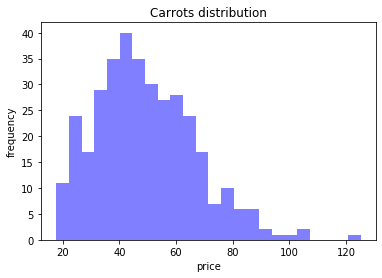

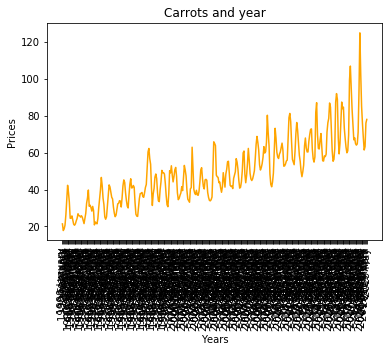

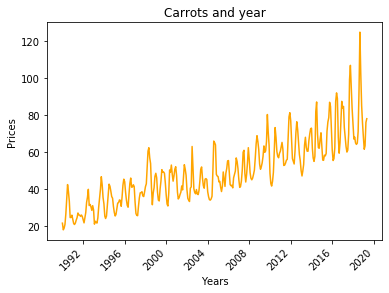

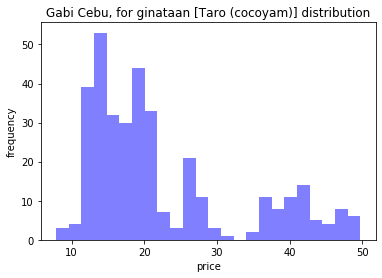

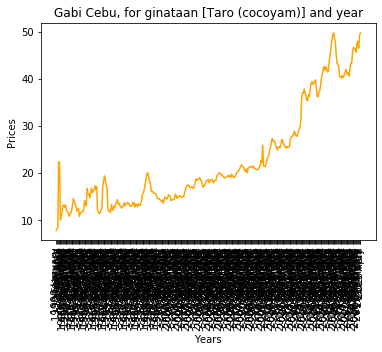

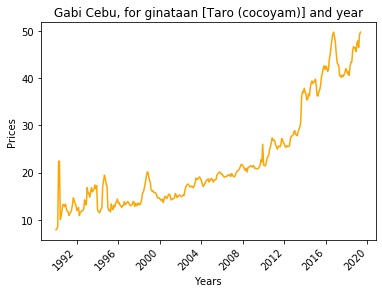

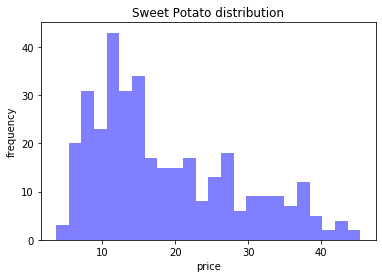

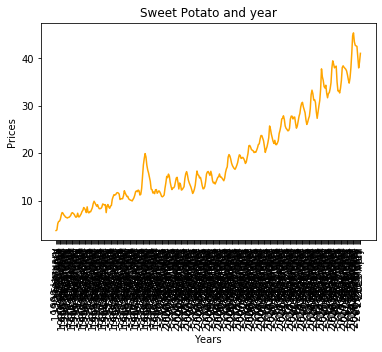

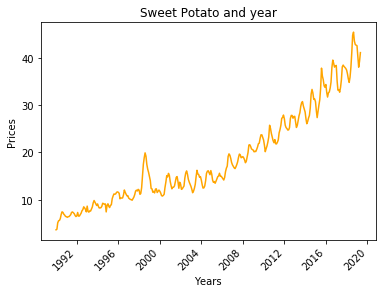

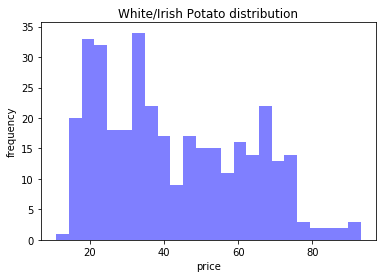

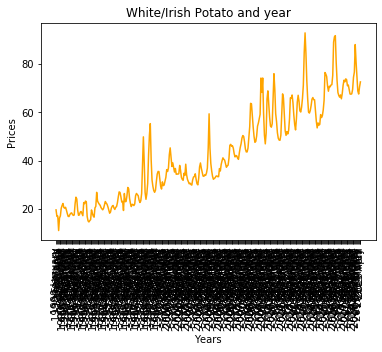

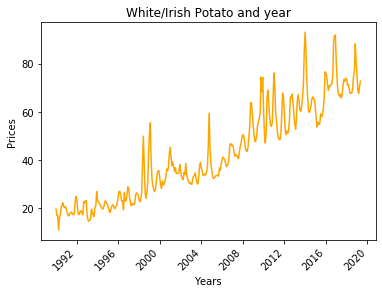

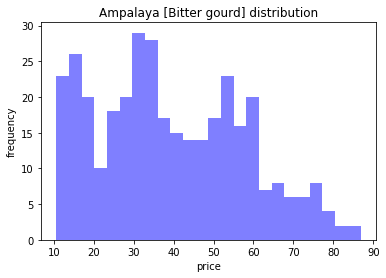

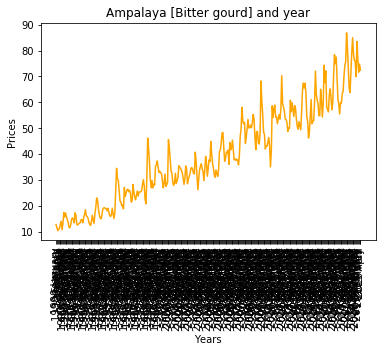

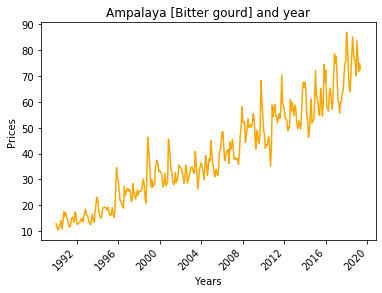

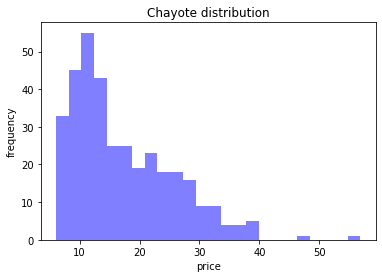

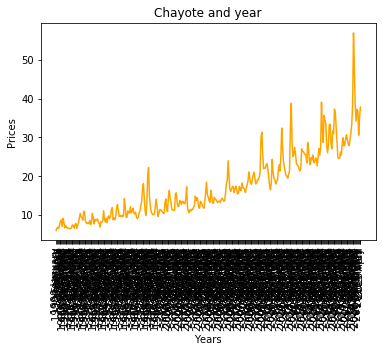

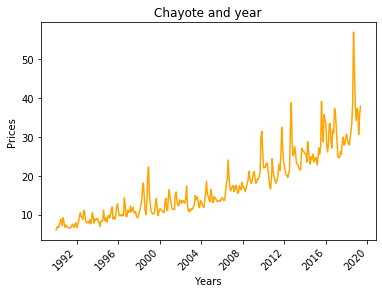

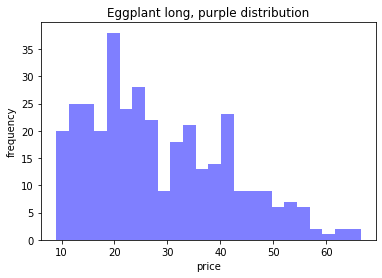

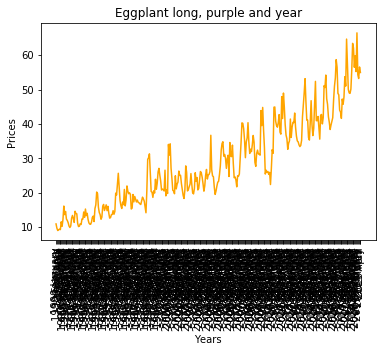

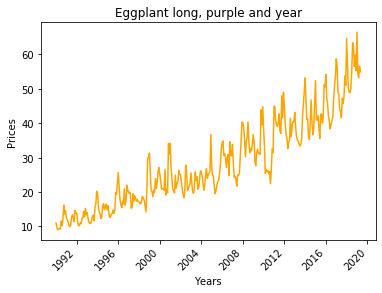

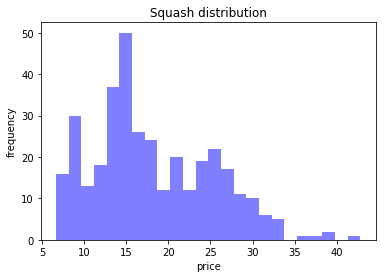

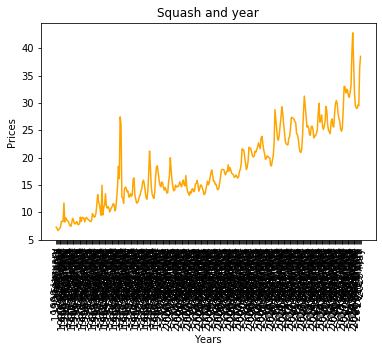

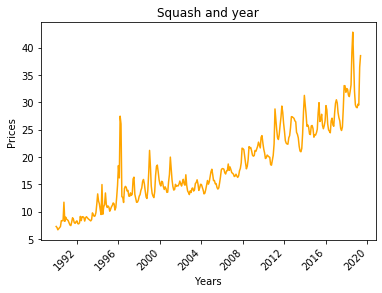

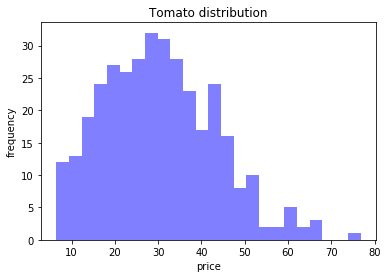

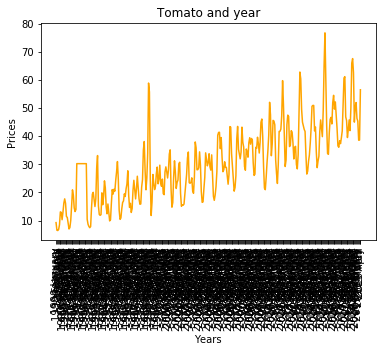

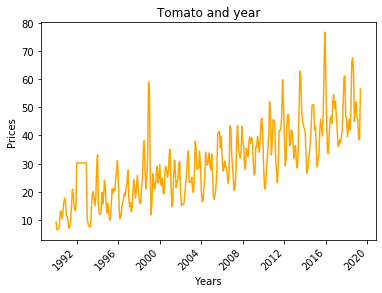

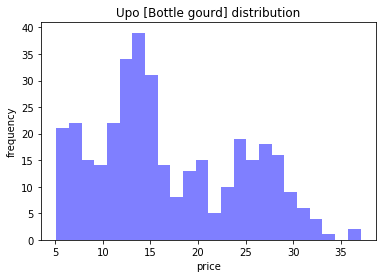

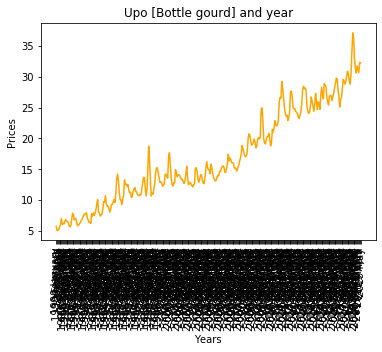

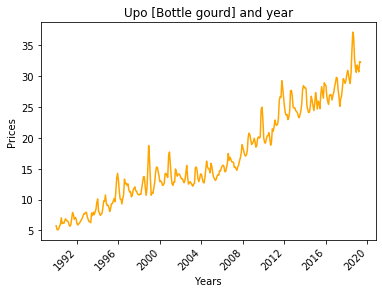

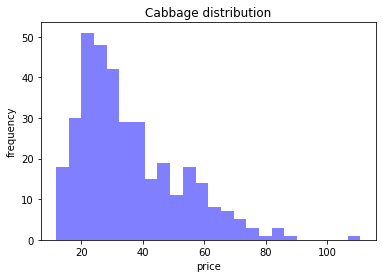

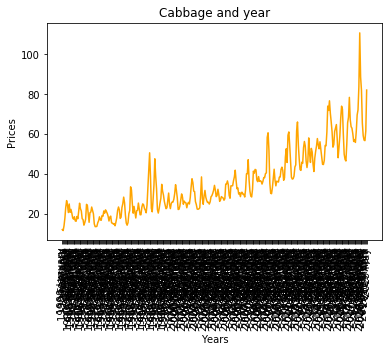

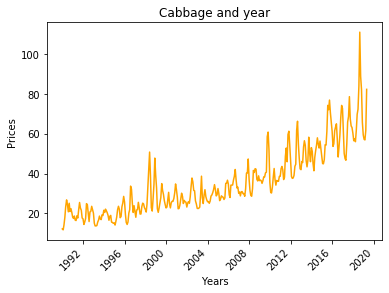

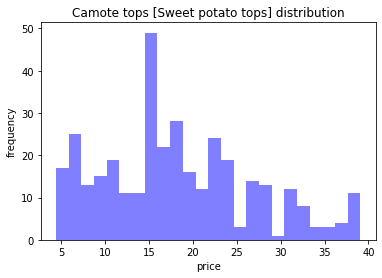

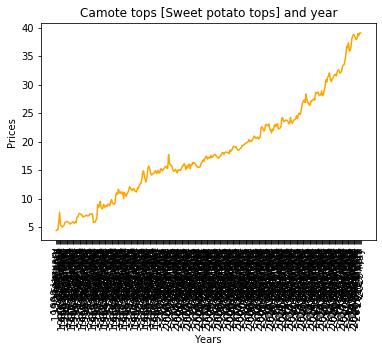

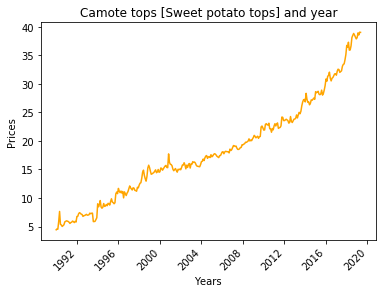

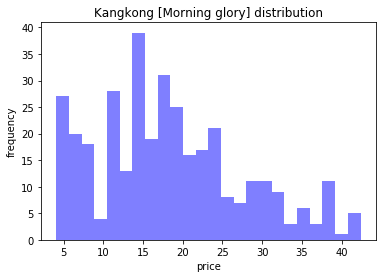

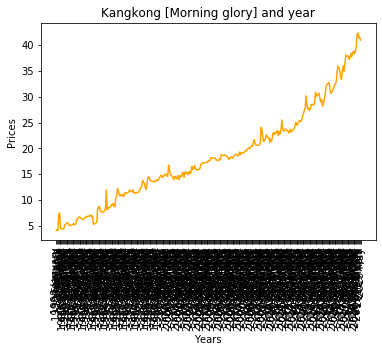

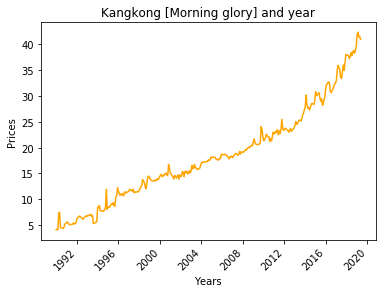

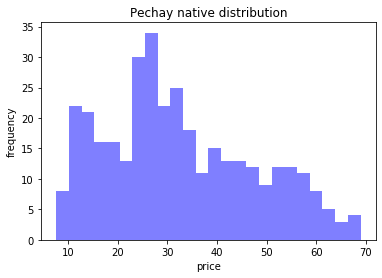

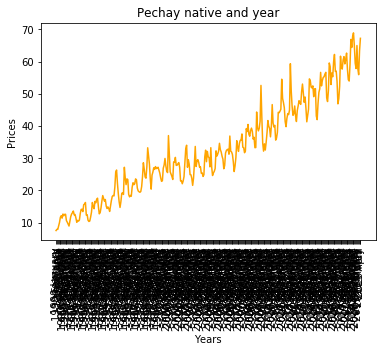

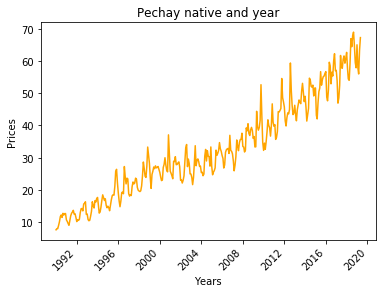

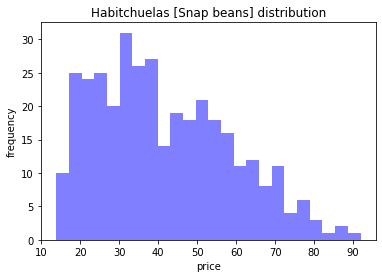

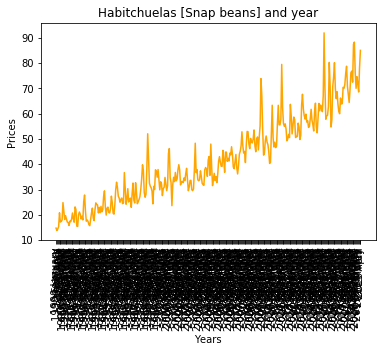

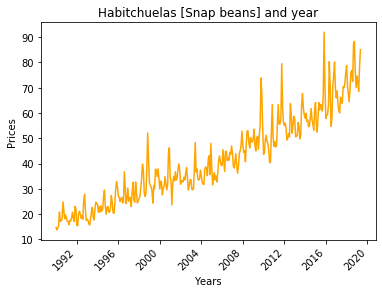

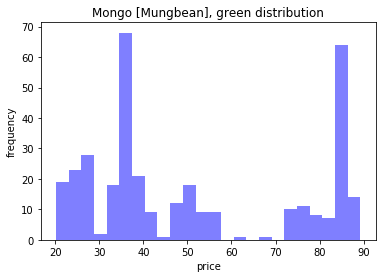

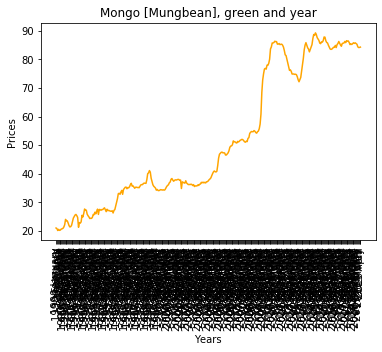

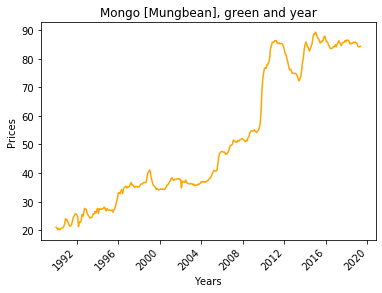

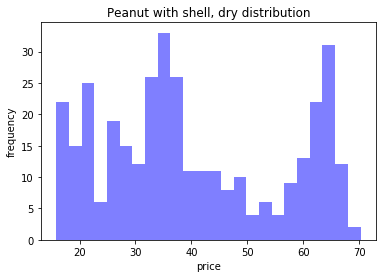

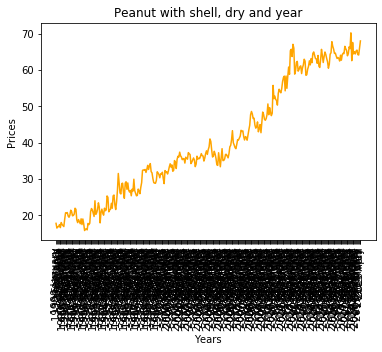

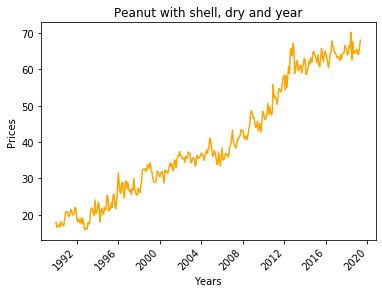

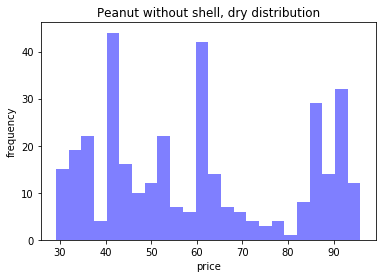

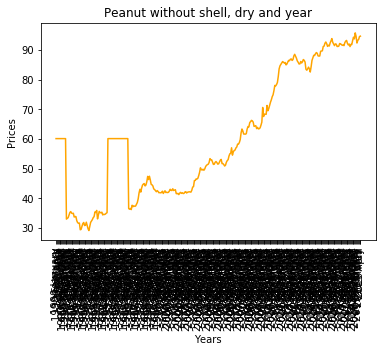

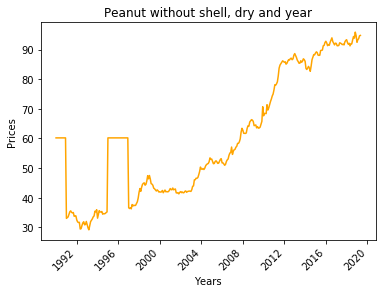

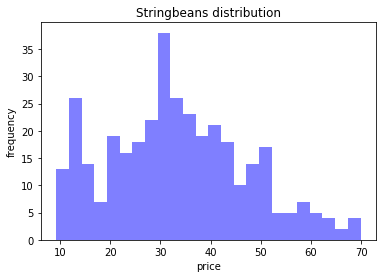

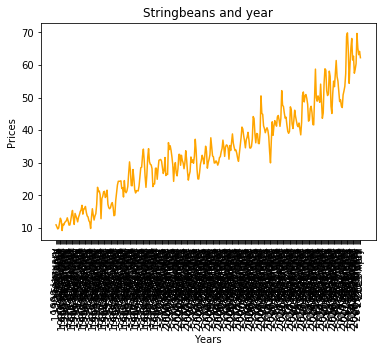

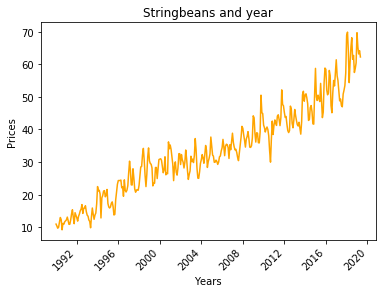

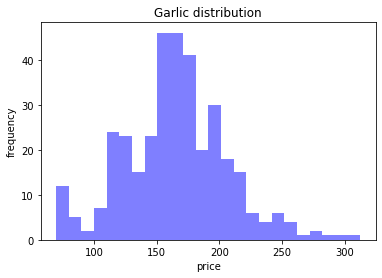

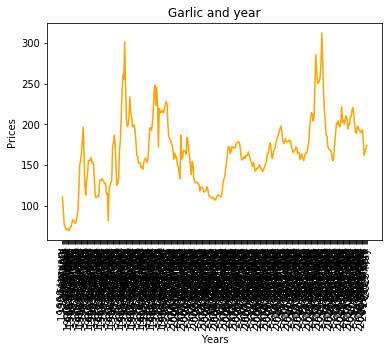

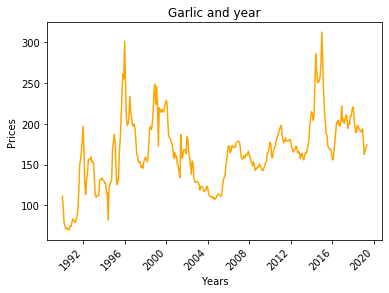

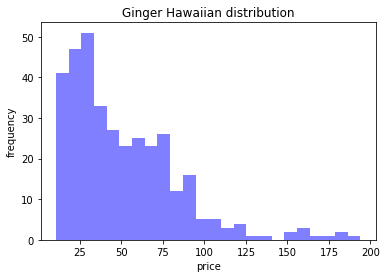

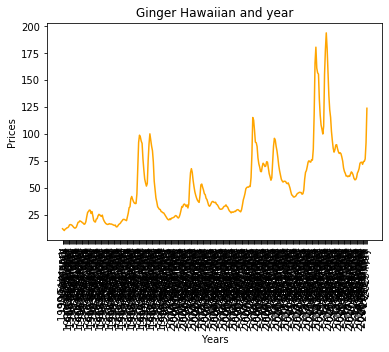

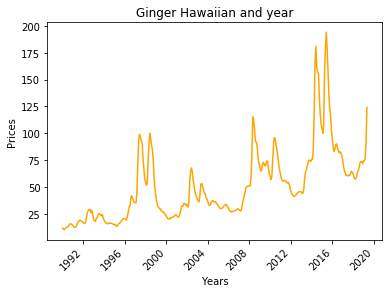

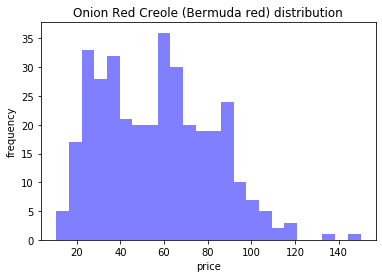

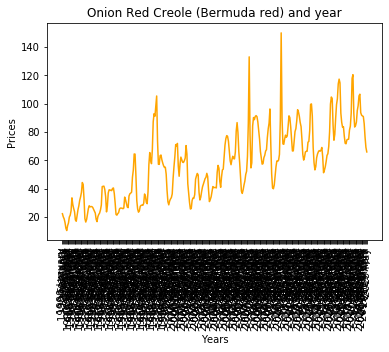

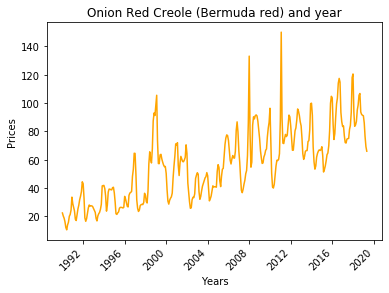

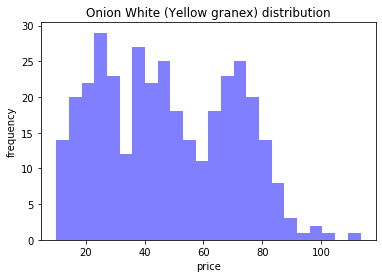

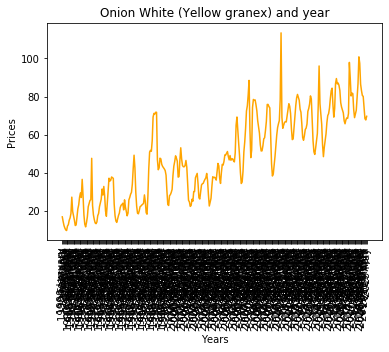

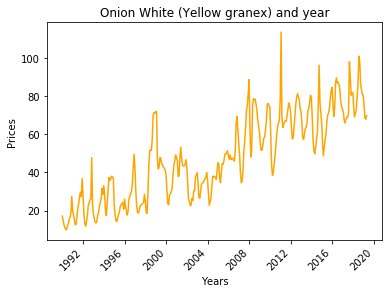

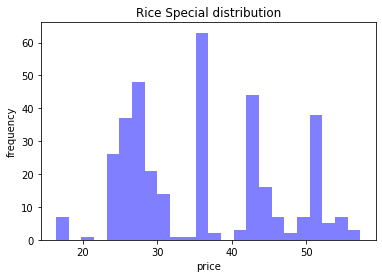

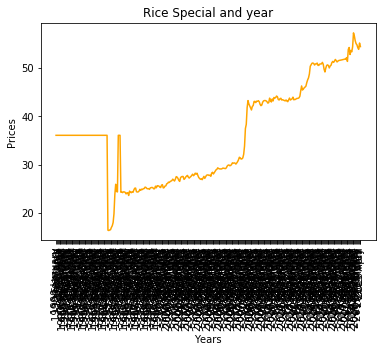

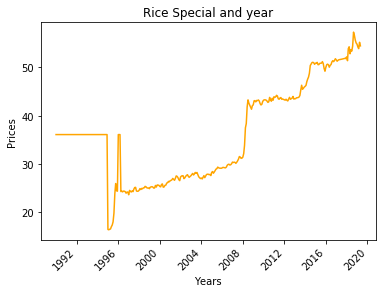

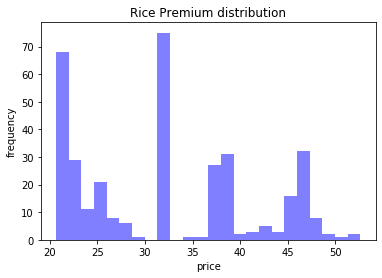

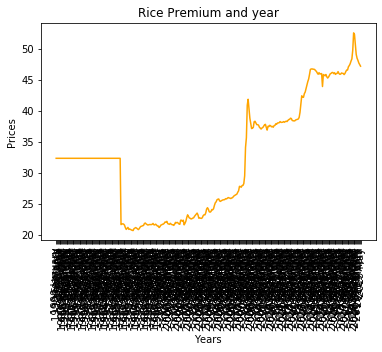

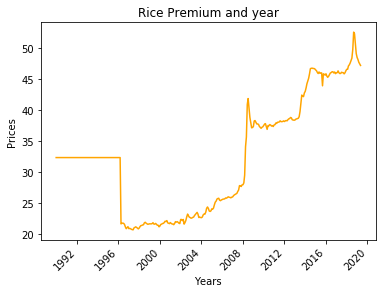

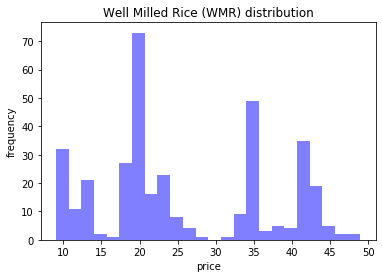

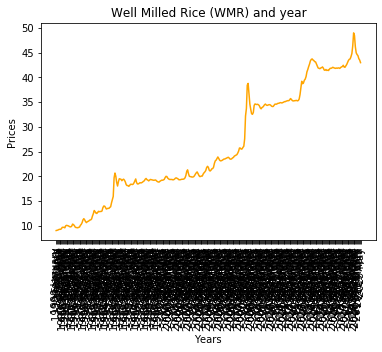

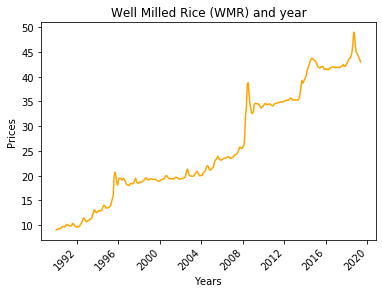

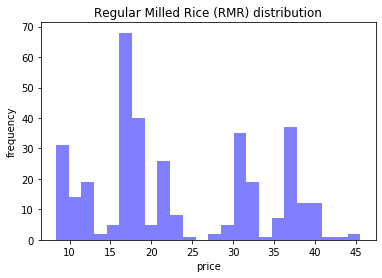

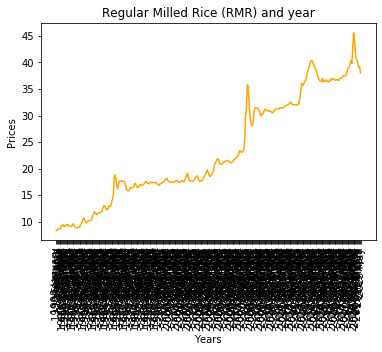

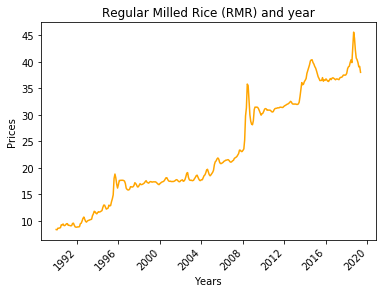

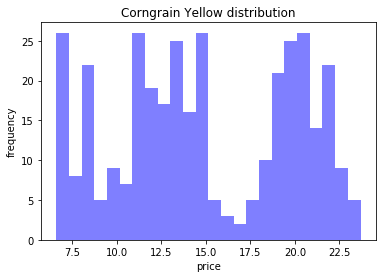

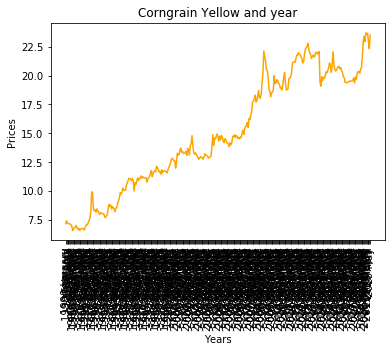

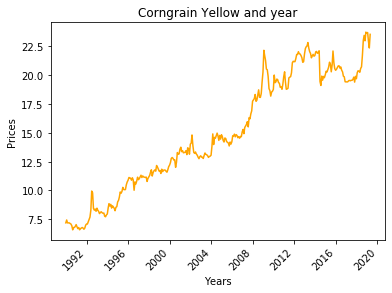

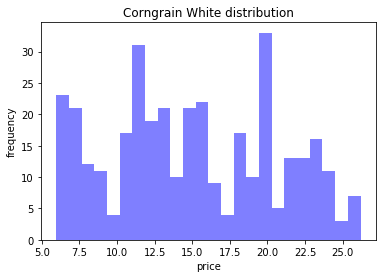

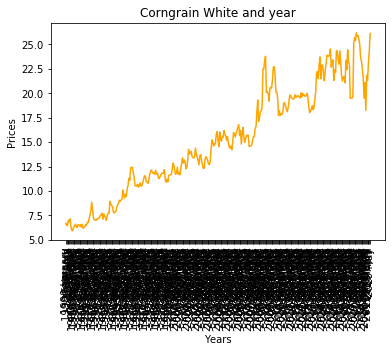

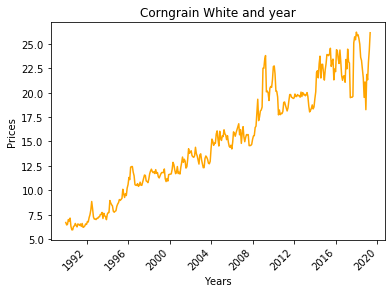

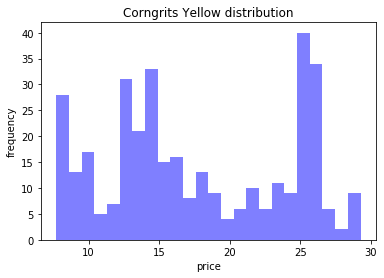

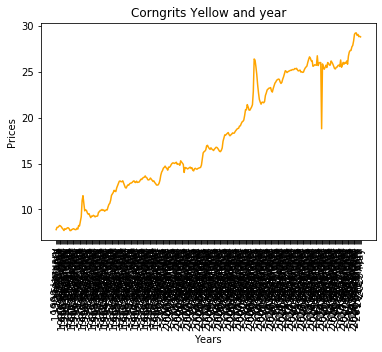

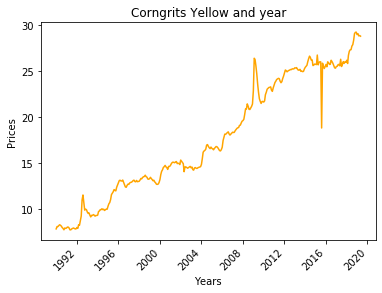

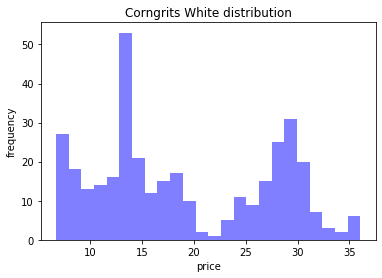

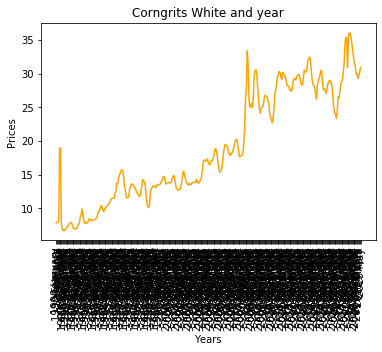

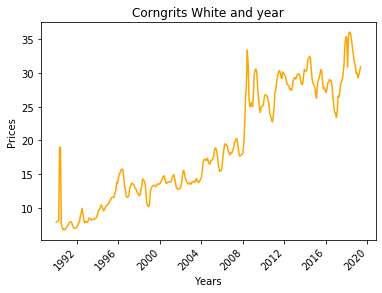

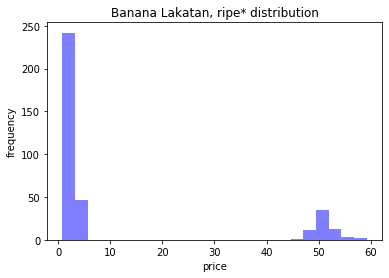

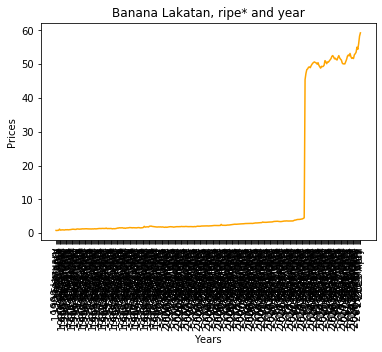

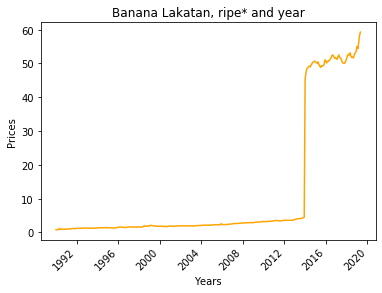

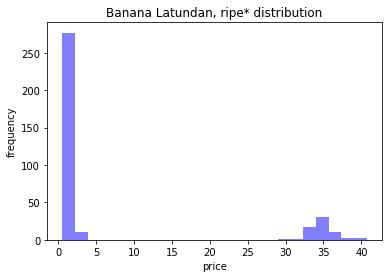

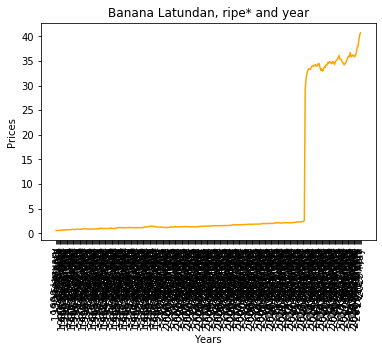

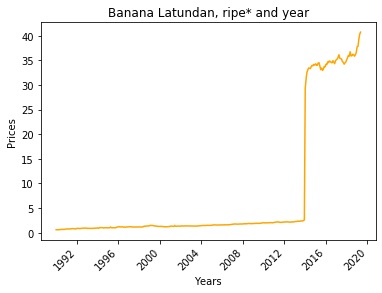

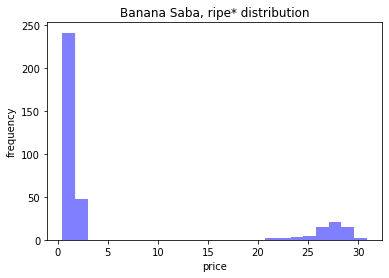

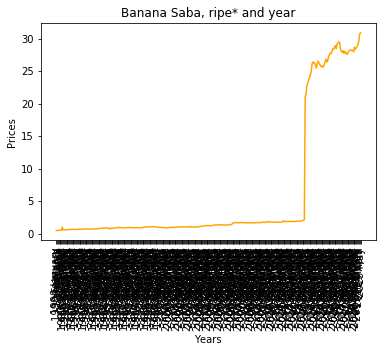

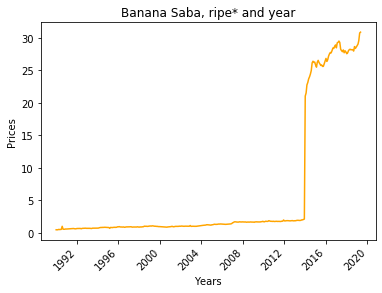

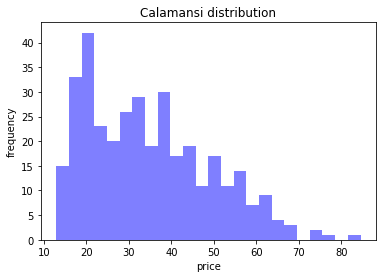

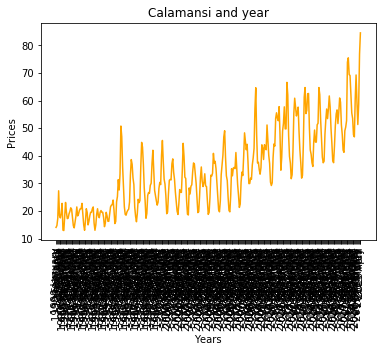

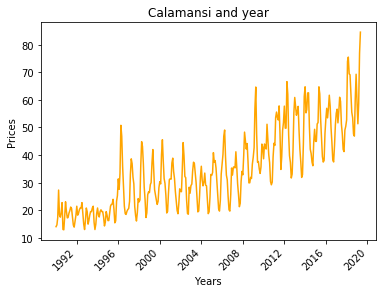

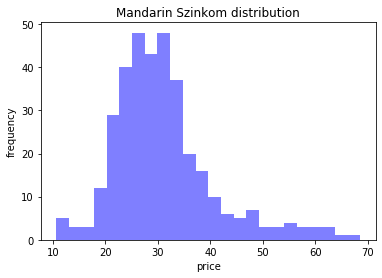

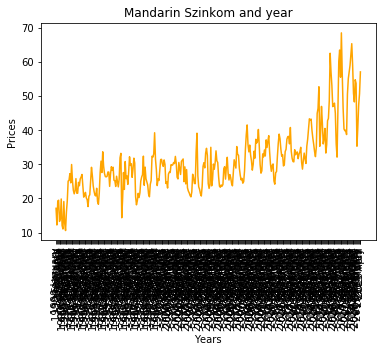

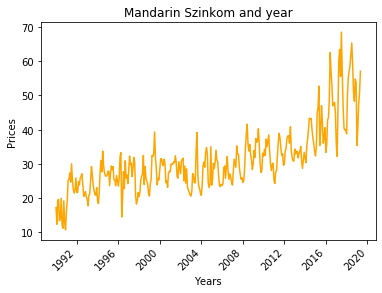

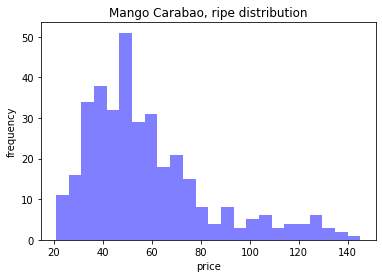

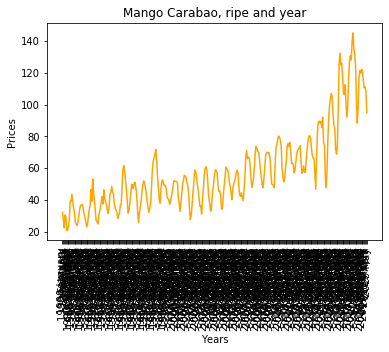

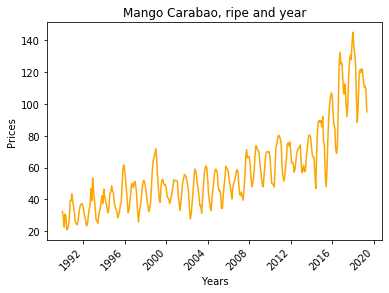

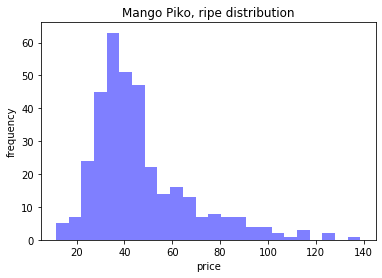

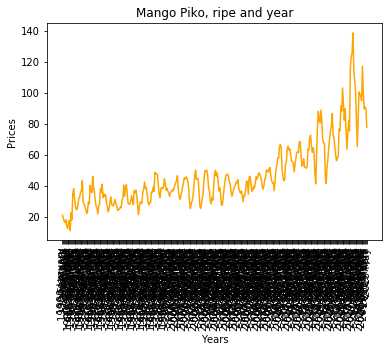

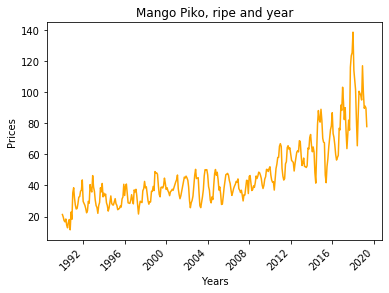

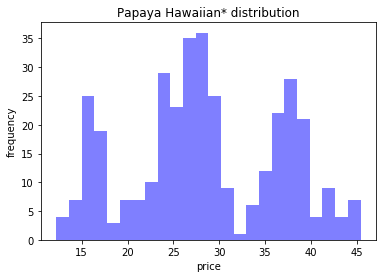

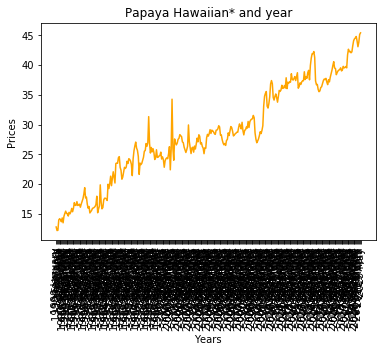

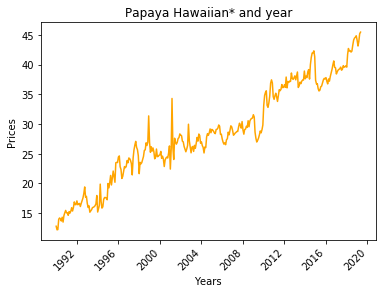

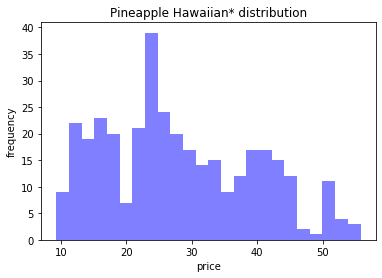

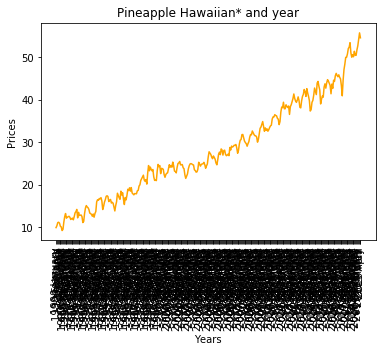

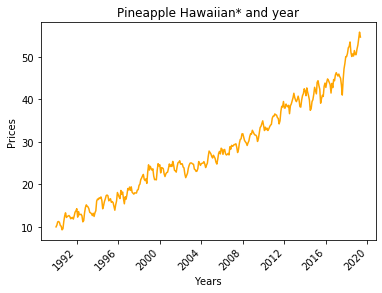

In [31]:
geofiles = [f for f in listdir(geofolder) if isfile(join(geofolder, f))]
national_cpi =[]
for x in geofiles:
    if 'Processed' in x and 'CPI' not in x:
        national_cpi.append(x)
        
        
def histo_graph():
    for file in national_cpi:
        province = pd.read_csv(DSDATA / 'FOOD_BY_GEO' / file , encoding = "ISO-8859-1")
        display(province)
        #province = normaliser(province)
    #hist = province.hist(bins=10000,histtype='step')
        num_bins = 24
        for x in range(province.shape[0]):
            province =province[province.columns.drop(list(province.filter(regex='Annual')))]
            n, bins, patches = plt.hist(province.iloc[x,2:].astype(float), num_bins, facecolor='blue', alpha=0.5)
            plt.xlabel('price')
            plt.ylabel('frequency')
            plt.title( province.iloc[x,1] +' distribution')
            plt.show()
            plt.plot(list(province.columns[2:]),province.iloc[x,2:], color='orange')
            plt.xlabel('Years')
            plt.ylabel('Prices')
            plt.xticks(rotation=90)
            plt.title( province.iloc[x,1]+' and year')
            plt.show()
           
            years = pd.to_datetime(pd.Series(list(province.columns[2:])), format='%Y %B')
            plt.plot(years,province.iloc[x,2:], color='orange')
            plt.xlabel('Years')
            plt.ylabel('Prices')
            plt.xticks(rotation=45, ha='right')
            plt.title( province.iloc[x,1]+' and year')
            plt.show()

histo_graph()   

In [ ]:
print(national_cpi)

In [ ]:
geofiles

# inferential statistics using t-test one sample

## Step 1: Formulate the null hypothesis $H_0$ and the alternative hypothesis $H_a$. 
These hypotheses must be written in such a way that they are nonoverlapping.

$H_0$: $\mu = 1070$ The mean of the crops prices for the last 10 years is same as . 

$H_a$: $\mu < 1070$ The mean energy intake of children 1 to 3 years old in the region is lower than 1070 kcal.

In [ ]:
mu = 240
n = len(wind_speeds)

print("Population mean mu =",mu)
print("Sample size n =", n)

#chose significance
alpha = 0.05

#calculate for the decision rule
from scipy.stats import t

# equivalent to t-table lookup
critical_value = t.ppf(1 - alpha, n-1) # 1 - alpha because we're testing for mu > 240
print("Critical Value", critical_value)

print("Decision Rule: Reject null hypothesis if t > {:0.3f}. Otherwise, fail to reject null hypothesis"
      .format(critical_value))

#Compute for the value of the test statistic from the sample data.
x_bar = np.mean(wind_speeds) # sample mean
s = np.std(wind_speeds) #sample standard deviation
print("Sample mean x_bar =",x_bar)
print("Sample standard deviation s =",s)

t = (x_bar - mu) / (s / np.sqrt(n)) # test statistic
print("Test statistic t =", t)

# Step 6: Make a decision.
#Since the value of t does not fall in the critical region, that is –0.9313 $\not>$ 1.7459, then we fail to reject $H_0$.

# Step 7: Make a conclusion
#At $\alpha = 5\%$, you have enough evidence to support the claim that the highest recorded average wind speed of the strongest typhoons entering the country after 1960 is equal to 240 km/h.

In [ ]:
#or (two tailed)
# if pval more than .05 then accpet null hypothesis
#scipy.stats.ttest_1samp
#sample  stats.ttest_1samp(rvs,5.0)
#H0: μ = m0
#H1: μ (true mean)≠ m0    (two-tailed)
#H1: μ > m0    (upper-tailed)
#H1: μ < m0    (lower-tailed)

for file in national_f:
    national = pd.read_csv(DSDATA / 'FOOD_BY_GEO' / file , encoding = "ISO-8859-1")
    known_ave 

In [ ]:
#last 5,10,20 years 
df = data_try.filter(regex='Annual')

data_try.iloc[:,-5:]
#average of 2019 as of may 2019
    

In [ ]:
data_try.iloc[1,-5:].mean()
one_sample = stats.ttest_1samp([1,3,6,8,23], 90)
one_sample.pvalue

# H0: μ = m0
# H1: μ (true mean)≠ m0    (two-tailed)
if pval more than .05 then accpet null hypothesis

In [ ]:
def one_sample(data, year):
    reject_th0 = []
    accept_th0 = []
    # go through all the rows
    years = year * -1
    data_filtered = data.filter(regex='Annual')
    for x in range(data.shape[0]):
        #average of the current year
        known_mean = data.iloc[x,-5:].mean()
        #dataframe that has the anual table
        sample = data_filtered.iloc[x,years:]
        one_sample = stats.ttest_1samp(sample, known_mean)
        if one_sample.pvalue >0.05 :
            accept_th0.append(data.loc[x,'Commodity'])
        else:
            reject_th0.append(data.loc[x,'Commodity'])
    
    print('REJECT')
    print(reject_th0)
    print(len(reject_th0)/data.shape[0])
    print('ACCEPT')
    print(accept_th0)
    print(len(accept_th0)/data.shape[0])
    #return reject_th0,accept_th0

In [ ]:
national_f

# Machine learning
- ARIMA model to predict CPI
- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
## parameters
    - p: The number of lag observations included in the model, also called the lag order.
    - d: The number of times that the raw observations are differenced, also called the degree of differencing.
    - q: The size of the moving average window, also called the order of moving average.
    - source: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
    - source: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [33]:
df = pd.read_excel(open(cpifolder/"prices2012.xls","rb"), sheet_name='PH',skiprows =2)
df['Year'] = [str(x) for x in df['Year']]
df['date'] = df[['Year', 'Month']].apply(lambda x: ' '.join(x), axis=1)

# Parsing the cpi's year and month to datetime datatype

In [34]:
official_date = []
for x in cpi_all['date']:
    date_time_str = x
    date_time_obj = datetime.strptime(date_time_str, '%Y %b')
    official_date.append(date_time_obj.date())
df['official_date'] = official_date

df['official_date']  = df['official_date'].astype('datetime64[ns]') 


NameError: name 'cpi_all' is not defined

In [37]:
print(df.info()) # shows that the df ['official_date'] is datetime data type
#df= df[['All Items','official_date']]
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 15 columns):
Year                                                                    737 non-null object
Month                                                                   737 non-null object
All Items                                                               737 non-null float64
Food and Non-Alcoholic Beverages                                        305 non-null float64
Alcoholic Beverages and Tobacco                                         305 non-null float64
Clothing and Footwear                                                   305 non-null float64
Housing, Water, Electricity,  Gas, and other Fuels                      305 non-null float64
Furnishing, Household Equipment and Routine Maintenance of the House    305 non-null float64
Health                                                                  305 non-null float64
Transport                                                   

Year Month  All Items  Food and Non-Alcoholic Beverages  \
0  1958   Jan   1.045350                               NaN   
1  1958   Feb   1.045350                               NaN   
2  1958   Mar   1.037663                               NaN   
3  1958   Apr   1.037663                               NaN   
4  1958   May   1.045350                               NaN   

   Alcoholic Beverages and Tobacco  Clothing and Footwear  \
0                              NaN                    NaN   
1                              NaN                    NaN   
2                              NaN                    NaN   
3                              NaN                    NaN   
4                              NaN                    NaN   

   Housing, Water, Electricity,  Gas, and other Fuels  \
0                                                NaN    
1                                                NaN    
2                                                NaN    
3                                                NaN    
4                                                NaN    

   Furnishing, Household Equipment and Routine Maintenance of the House  \
0                                                NaN                      
1                                                NaN                      
2                                                NaN                      
3                                                NaN                      
4                                                NaN                      

   Health  Transport  Communication  Recreation and Culture  Education  \
0     NaN        NaN            NaN                     NaN        NaN   
1     NaN        NaN            NaN                     NaN        NaN   
2     NaN        NaN            NaN                     NaN        NaN   
3     NaN        NaN            NaN                     NaN        NaN   
4     NaN        NaN            NaN                     NaN        NaN   

   Restaurants and Miscellaneous Goods and Services      date  
0                                               NaN  1958 Jan  
1                                               NaN  1958 Feb  
2                                               NaN  1958 Mar  
3                                               NaN  1958 Apr  
4                                               NaN  1958 May

In [39]:
series = pd.Series(df['All Items'])
#series.index = list(df['official_date'])
series

0        1.045350
1        1.045350
2        1.037663
3        1.037663
4        1.045350
          ...    
732    119.100000
733    119.300000
734    119.300000
735    119.600000
736    119.800000
Name: All Items, Length: 737, dtype: float64

# The data is also plotted as a time series with the month and year along the x-axis and cpi on the y-axis.
- We can see that the cpi dataset has a clear trend.
- This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.
- Let’s also take a quick look at an autocorrelation plot of the time series. This is also built-in to Pandas. The example below plots the autocorrelation for a large number of lags in the time series.

In [ ]:
plt.plot(df.index, df['All Items'], color='orange')
plt.xlabel('Date and month')
plt.ylabel('cpi value')
plt.title('Cpi values in the Philippines')
plt.show()

# Autocorrelation

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['All Items'])
plt.show()

In [ ]:

from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
 

# fit model
model = ARIMA(df['All Items'], order=(6,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [40]:
df1 = pd.read_excel(open(cpifolder/"prices2012.xls","rb"), sheet_name='PH',skiprows =2)
df2 = pd.DataFrame()

# Differencing or not (P VAL more than significance value so yeah)

In [42]:
df2['value'] = df1['All Items']
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df2.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: 3.113074
p-value: 1.000000


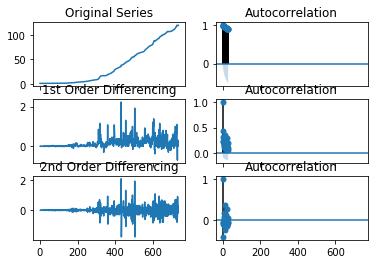

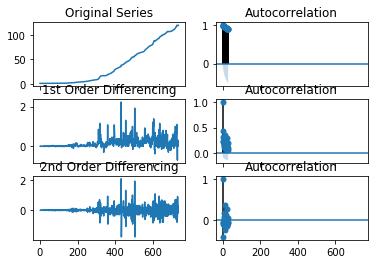

In [44]:
# Import data
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df2.value); axes[0, 0].set_title('Original Series')
plot_acf(df2.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df2.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df2.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df2.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df2.value.diff().diff().dropna(), ax=axes[2, 1])

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df2.value.diff()); axes[0].set_title('1st Differencing')
#axes[1].set(ylim=(0,5))
plot_pacf(df2.value.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})



fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df2.value.diff()); axes[0].set_title('1st Differencing')
#axes[1].set(ylim=(0,1.5))
plot_acf(df2.value.diff().dropna(), ax=axes[1])

plt.show()

In [49]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df2.value[:626]
test = df2.value[626:]

In [ ]:
train

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  625
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  89.821
Method:                       css-mle   S.D. of innovations              0.209
Date:                Fri, 16 Aug 2019   AIC                           -171.641
Time:                        20:19:59   BIC                           -153.890
Sample:                             1   HQIC                          -164.744
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1457      0.033      4.439      0.000       0.081       0.210
ar.L1.D.value     0.9256      0.031     29.445      0.000       0.864       0.987
ma.L1.D.value    -0.7041      0.067    -

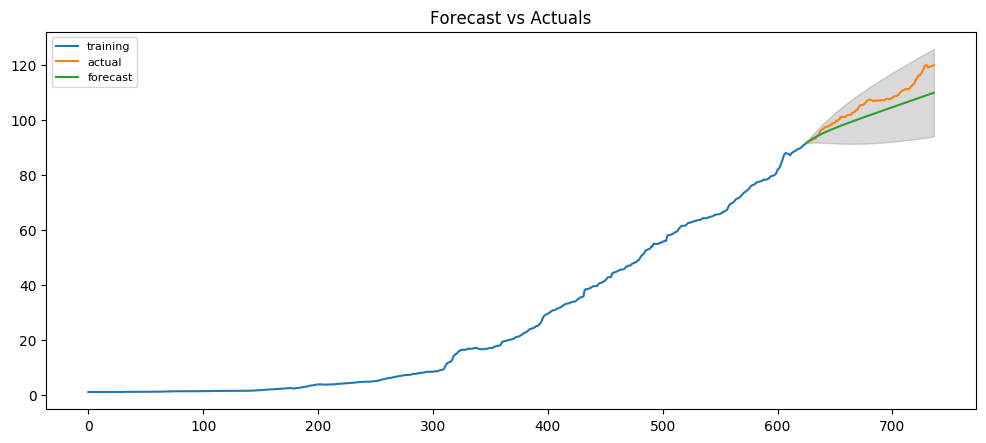

In [56]:
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(111, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [57]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 0.037906578065037375,
 'me': -4.125024743589925,
 'mae': 4.160595557609576,
 'mpe': -0.037522897576742174,
 'rmse': 4.946243370201701,
 'acf1': 0.9607610862186938,
 'corr': 0.9848429043060892,
 'minmax': 0.03790581174848828}

In [ ]:
df1.columns

In [47]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

model = pm.auto_arima(df2.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 1, 1); AIC=-92.606, BIC=-74.201, Fit time=0.165 seconds
Fit ARIMA: order=(0, 1, 0); AIC=92.292, BIC=101.494, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-59.410, BIC=-45.606, Fit time=0.028 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-14.213, BIC=-0.410, Fit time=0.029 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-114.993, BIC=-91.987, Fit time=0.340 seconds
Fit ARIMA: order=(2, 1, 0); AIC=-76.152, BIC=-57.747, Fit time=0.056 seconds
Fit ARIMA: order=(2, 1, 2); AIC=-83.228, BIC=-55.620, Fit time=1.019 seconds
Fit ARIMA: order=(3, 1, 2); AIC=-118.942, BIC=-86.734, Fit time=0.725 seconds
Fit ARIMA: order=(3, 1, 1); AIC=-116.223, BIC=-88.616, Fit time=0.957 seconds
Fit ARIMA: order=(3, 1, 3); AIC=-97.583, BIC=-60.773, Fit time=3.747 seconds
Total fit time: 7.080 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  736
Model:                 ARIMA(3, 1, 2)   L

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  625
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  79.497
Method:                       css-mle   S.D. of innovations              0.213
Date:                Fri, 16 Aug 2019   AIC                           -150.995
Time:                        20:17:06   BIC                           -133.244
Sample:                             1   HQIC                          -144.098
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1451      0.019      7.810      0.000       0.109       0.181
ar.L1.D.value     0.3875      0.040      9.804      0.000       0.310       0.465
ar.L2.D.value     0.1549      0.040     

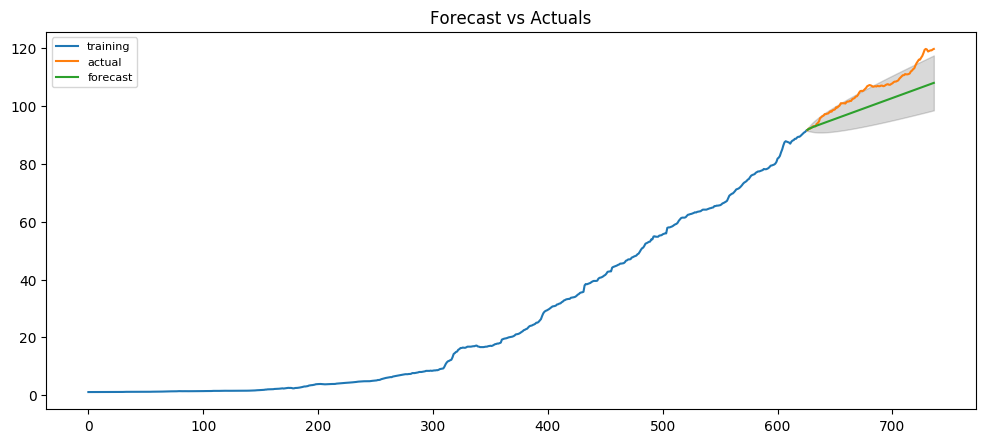

In [50]:
model = ARIMA(train, order=(2, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(111, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [51]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

/Users/macbookpro/Desktop/DLSU/9th_Term/DATASCI/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


{'mape': 0.051070320998770485,
 'me': -5.5643243779628,
 'mae': 5.571711754889461,
 'mpe': -0.05099023841109882,
 'rmse': 6.3323440222639515,
 'acf1': 0.9593109203265913,
 'corr': 0.9840395496606842,
 'minmax': 0.05107027450267754}